# Attività Text Analytics e Graph Analytics  
### Gabriele Savoia  

## 1. Introduzione  

L'ambito applicativo di questo progetto riguarda l'analisi di questionari Instant Feedback e delle relazioni tra i clienti e le filiali in riferimento ai dati messi a disposizione dalla banca Credit Agricole Italia. In particolare: **1)** tramite l'analisi dei questionari (composti da risposte chiuse e aperte) si vogliono sviluppare e confrontare modelli di Sentyment Analysis in grado di associare un sentimento (positivo o negativo) ad una certa risposta aperta così da calcolare in maniera più precisa il livello di soddisfazione del cliente; **2)** sulla base dei dati relativi ai collegamenti tra i clienti e le filiali, è stato creato il relativo grafo su cui sono poi applicati opportuni algoritmi al fine di ricavare elementi rilevanti come le reti di influenza dei clienti più soddisfatti, ma in generale anche il livello di soddisfazione delle filiali.  

Il progetto è suddiviso nella seguente modalità: nella sezione 2 è riportato il codice e la descrizione per il caricamento dei dati utilizzati; nella 3 sono descritte, implementate e testate le diverse metodologie di machine learning per l'analisi del sentimento del testo libero; infine nella sezione 4 sono riportate le diverse tecniche utilizzate per poter raggiungere i due obiettivi fissati.

Per lo svliluppo delle funzionalità appena riportate, sono state utilizzate le seguenti librerie.

In [318]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import resample, shuffle
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

import plotly.express as plotly_express
import plotly.graph_objects as plotly_go

import matplotlib.pyplot as plt
import scikitplot as skplt

import nltk
from nltk.tokenize import word_tokenize

import emoji
import spacy
from spacy.tokenizer import Tokenizer

import statistics
import random

from py2neo import Graph

## 2. Analisi dei dati  

In questa sezione sono descritti i dati messi a disposizione dalla banca Credit Agricole in relazione ai due obiettivi riportati nel paragrafo precedente.  
In particolare sono presenti due file (di testo) distinti per ciascuna delle due parti: il file relativo ai questionari è situato in *'./dataset/Dataset1_Risposte_Questionari.txt'*, mentre quello riferito alle relazioni dei clienti si trova in *'./dataset/Dataset2_Collegamenti_Clienti.txt'.* Nei sotto-paragrafi seguenti è riportata l'analisi di ciascuno dei dataset con le relative statistiche generali.

### 2.1 Dataset questionari  

Di seguito è riportato il codice utilizzato per il caricamento del dataset relativo ai questionari valutati. Come si può vedere dal dataframe caricato, ogni riga (805943 in totale) si riferisce ad una singola domanda (*ID_DOMANDA*, *DESC_DOMANDA*) e la relativa risposta (*TIPO_RISPOSTA*, *DESC_RISPOSTA*) in riferimento ad un certo questionario (*ID_QUESTIONARIO*, *DESC_QUESTIONARIO*, *ID_SESSIONE_QUESTIONARIO*) compilato da un cliente (*ID_CLIENTE*).

In [2]:
DATASET_QUESTIONARI = './dataset/Dataset1_Risposte_Questionari.txt'

df_questionari = pd.read_csv(DATASET_QUESTIONARI, sep='\t')
print('Dimensione dataframe: \nrighe: {0}, colonne: {1}'.format(df_questionari.shape[0], 
                                                                df_questionari.shape[1]))
display(df_questionari.head(3))


Dimensione dataframe: 
righe: 805943, colonne: 9


,ID_CLIENTE,ID_QUESTIONARIO,DESC_QUESTIONARIO,ID_SESSIONE_QUESTIONARIO,DATA_COMPILAZIONE,ID_DOMANDA,DESC_DOMANDA,TIPO_RISPOSTA,DESC_RISPOSTA
0,6149323,17,Apertura cc online,534695,2021-02-03,5275,Come sei venuto a conoscenza di Conto Crédit A...,inputradio,in-filiale-Cr-dit-agricole
1,6149323,17,Apertura cc online,534695,2021-02-03,5276,Quanto sei soddisfatto della tua esperienza di...,inputradio,Abbastanza
2,6149323,17,Apertura cc online,534695,2021-02-03,5277,Come valuti il tempo impiegato per il processo...,inputradio,soddisfacen


Come primo passo di elaborazione, sono stati analizzati i valori nulli presenti nel dataframe ed è stato visto che sono presenti quasi 70000 NaN in riferimento alla colonna *DESC_RISPOSTA*. Essendo quindi queste domande non informative è stato deciso di eliminarle dal dataframe.

In [3]:
# Eliminazione nan
print('\nNan nel dataframe:')
display(df_questionari.isnull().sum())
df_questionari = df_questionari.dropna()
df_questionari['DESC_RISPOSTA'] = df_questionari['DESC_RISPOSTA'].str.lower()
print('Dimensione dopo la rimozione dei Nan: \nrighe: {0}, colonne: {1}'.format(df_questionari.shape[0], 
                                                                                df_questionari.shape[1]))


Nan nel dataframe:


ID_CLIENTE                      0
ID_QUESTIONARIO                 0
DESC_QUESTIONARIO               0
ID_SESSIONE_QUESTIONARIO        0
DATA_COMPILAZIONE               0
ID_DOMANDA                      0
DESC_DOMANDA                    0
TIPO_RISPOSTA                   0
DESC_RISPOSTA               69391
dtype: int64

Dimensione dopo la rimozione dei Nan: 
righe: 736552, colonne: 9


### 2.2 Dataset relazioni  

Per quanto riguarda il dataset delle relazioni tra clienti e filiali, di seguito è riportato il codice relativo al corripsettivo caricamento in un dataframe pandas. Come si può vedere, per ogni riga sono presenti le informazioni di ciascuna relazione (4089536), ovvero il nodo sorgente e destinazione (*CLIENTE_1* e 2) con il reltivo codice di natura giuridica (*COD_NATURA_GIURIDICA_1* e 2) e la filiale di appartenenza (*ID_FILIALE_1* e 2). Ogni relazione ha inoltre un certo codice di collegamento (*COD_COLLEGAMENTO*) con la relativa descrizione (*DESC_COLLEGAMENTO*).  

Essendo che nel dataset di partenza la colonna relativa all'id del cliente 1 è chiamata *ID_CLIENTE*, è stato effettuato un rename in *ID_CLIENTE_1.*

In [4]:
DATASET_RELAZIONI = './dataset/Dataset2_Collegamenti_Clienti.txt'

df_relazioni = pd.read_csv(DATASET_RELAZIONI, sep='\t')
print('Dimensione e visualizzazione dataframe: \nrighe: {0}, colonne: {1}'.format(df_relazioni.shape[0], 
                                                                                  df_relazioni.shape[1]))
df_relazioni = df_relazioni.rename(columns={'ID_CLIENTE': 'ID_CLIENTE_1'})
display(df_relazioni.head(3))

Dimensione e visualizzazione dataframe: 
righe: 4089536, colonne: 8


,ID_CLIENTE_1,COD_NATURA_GIURIDICA_1,ID_FILIALE_1,COD_COLLEGAMENTO,DESC_COLLEGAMENTO,ID_CLIENTE_2,COD_NATURA_GIURIDICA_2,ID_FILIALE_2
0,6123972,DI,28438,R01,TIT. DITTA INDIV.,6482323,PF,28438
1,6123981,DI,28638,R01,TIT. DITTA INDIV.,6173394,PF,28638
2,6123989,PF,45955,I85,HA COME EREDE,6756182,PF,45955


Con il codice seguente è stato poi visto che non sono presenti elementi nulli nel dataframe.

In [5]:
print('\nNan nel dataframe:')
display(df_relazioni.isnull().sum())


Nan nel dataframe:


ID_CLIENTE_1              0
COD_NATURA_GIURIDICA_1    0
ID_FILIALE_1              0
COD_COLLEGAMENTO          0
DESC_COLLEGAMENTO         0
ID_CLIENTE_2              0
COD_NATURA_GIURIDICA_2    0
ID_FILIALE_2              0
dtype: int64

Essendo che per poter effettuare il punto **2** del progetto è necessario unire il dataset delle relazioni con le informazioni dei questionari del punto **1**, si vuole di seguito capire il numero numero di clienti che hanno compilato almeno un questionario nell'intero insieme di clienti di cui sono definite le relazioni.

In [6]:
clienti_1 = df_relazioni['ID_CLIENTE_1'].unique()
clienti_2 = df_relazioni['ID_CLIENTE_2'].unique()
clienti_con_relazioni = set(list(clienti_1)+list(clienti_2))

clienti_questionario = set(df_questionari['ID_CLIENTE'].unique())
clienti_con_relazioni_e_questionario = len(clienti_con_relazioni.intersection(clienti_questionario))

print('Clienti con relazioni (nodi nel grafo) : {}'.format(len(clienti_con_relazioni)))
print('Clienti con relazioni e con questionario compilato (nodi nel grafo con questionario compilato): {}'\
     .format(clienti_con_relazioni_e_questionario))


Clienti con relazioni (nodi nel grafo) : 3505346
Clienti con relazioni e con questionario compilato (nodi nel grafo con questionario compilato): 65772


Si può quindi vedere che su un totale di 3505346 nodi nel grafo, solo 65772 hanno compilato almeno un questionario, mentre degli altri non si hanno informazioni riguardo il grado di apprezzamento della banca.

## 3. Text Analytics  

Per la parte di Text Analytics del progetto, ci si è posti l'obiettivo di implementare, mediante librerie specifiche, opportune metodologie in grado di estrapolare informazioni utili dalle domande aperte al fine di migliorare il meccanismo di valutazione della soddisfazione dei clienti nella banca.  

In particolare, sono state utilizzate tecniche di Sentiment Analysis (e più in generale di text classification) al fine di associare un certo score di soddisfazione a ciascuna risposta a testo libero in relazione a ciò che è stato risposto nelle domande chiuse. Sono stati quindi utilizzati e confrontati diversi modelli di machine learning supervisionati il cui obiettivo è quello di classificare in maniera binaria (*positivo* (0) o *negativo* (1)) le risposte a testo libero inserite dall'utente.  

Le seguenti sotto-sezioni sono relative a: 3.1) trasformare il dataframe dei questionari in un dataframe predisposto al train per il modello di Sentiment Analysis (composto da due colonne: *testo libero* e relativo *target*); 3.2) descrizione della classe SentimentAnalyzer creata per gestire meglio le diverse tecniche considerate; 3.3) metodologia per la valutazione e confronto delle performance dei diversi modelli; 3.4) calcolo dello score finale per la parte di Graph Analytics.

### 3.1 Trasformazione in un dataframe adatto all'addestramento  

Il dataframe *df_questionari* creato in sezione 2.1 contiene per ciascuna riga le informazioni relative ad ogni singola domanda. Prima di procedere con la descrizione della trasformazione da eseguire per rendere i dati predisposti ad un addestramento supervisonato, sono di seguito riportate le possibili *risposte chiuse* e le possibili *domande aperte*.  

Per quanto riguarda le risposte chiuse (necessarie per definire i target per il modello di machine learning) sono presenti diversi tipi: *inputradio*, *inputmulticheckb*, *inputdate*, *inputmatrix*. Tra queste è stato visto che solamente quelle di tipo *inputradio* e *inputmulticheckb* risultano essere informative per la Sentiment Analysis. Considerando quindi solo queste tipologie, sono di seguito riportati le possibili risposte per ciascuna.

In [7]:
risposte_inputradio=df_questionari[df_questionari['TIPO_RISPOSTA']=='inputradio']['DESC_RISPOSTA'].unique()
print('Risposte inputradio: \n')
print(risposte_inputradio)

print('\n\nRisposte inputmulticheckb: \n')
risposte_inputmulti=df_questionari[df_questionari['TIPO_RISPOSTA']=='inputmulticheckb']['DESC_RISPOSTA'].unique()
print(risposte_inputmulti)

Risposte inputradio: 

['in-filiale-cr-dit-agricole' 'abbastanza' 'soddisfacen' 'v8' 'no'
 'passaparola' 'molto' 'eccellente' 'v10' 'sito' 'v9' 'in-filiale' 'v7'
 'pubblicit--online' 'sito-cr-dit-agricole-it' 'poco' 'nonadeguato'
 'eccessivo' 'si' 'v6' 'v5' 'per-niente' 'v3' 'v1' 'altro' 'social' 'v0'
 'convenienza' 'v4' 'v2' 'addebitorat' 'affidabilit' 'pocoutile'
 'abbastanzau' 'perniente' 'soddisfacente' 'filiale' 'almeno1volta' 'mai'
 'v3volte' 'infilialecrditagricole' 'condizionieconomiche'
 'serviziodiprevalutazione' 'laurea' 'affidabilitdicrditagricole'
 'professionalitdelgestorecrditagricole' 'sitocreditagricoleit'
 'pubblicitonline' 'comparatorionlineesmutuionline'
 'convenienzarispettoallealtrebanche'
 'lcompletarelapraticacompletamenteonline' 'diplomadiscuolasuperiore'
 'scontiperlacquistodiprodottieservizilegatiallacasaestraslocoservizipuliziedivigilanza'
 'licenzamedia' 'scontiperlacquistodiprodottieservizilegatiallacas'
 'caratteristichedelmutuocrditagricole' 'supportoonl

E' quindi possibile notare che non tutte le risposte (in riferimento alle due tipologie considerate) forniscono un'informazione utile in termini di soddisfazione verso la banca (ad esempio, tra le tante, le risposte *socialweb* o *cartaceo* per il tipo *inputradio* oppure *online* o *operare-in-autonomia* per il tipo *multicheckb*).  
Dall'altra parte però ne esistono alcune molto informative come *eccellente*, *abbastanza*, *soddisfacente* (per *inputradio*) e *comodo*, *veloce*, *complicato* (per *inputmulticheckb*). L'idea è quindi quella di associare ad ogni risposta chiusa un certo punteggio (un numero in riferimento ad una scala) che rispecchia il livello di gradimento dell'utente (es. assegnare un valore 0 a risposte di tipo *per-niente* e 5 a quelle come *eccellente* e valori intermedi per risposte intermedie).  

Per quanto riguarda invece le risposte aperte, all'interno del dataframe è possibile identificarle in quanto sono di tipo *inputtextarea*. Si vuole quindi adesso vedere, tra tutti i questionari per quali *domande* è richiesta una risposta aperta.

In [8]:
print('Domande inputtextarea: \n')
domande_inputtextarea=df_questionari[df_questionari['TIPO_RISPOSTA']=='inputtextarea']['DESC_DOMANDA'].unique()
print(domande_inputtextarea)

Domande inputtextarea: 

['Puoi argomentare questa tua valutazione?' 'Altro'
 'Cosa ci suggeriresti per migliorare la nuova funzionalità PUSH CODE?'
 'Hai ulteriori motivazioni?' 'Altro (specifica)'
 'Hai dei suggerimenti per aiutarci a migliorare?'
 'Quale aspetto di Mutuo Crédit Agricole ti è piaciuto di più?_1'
 'Altro_1' 'Puoi argomentare questa tua valutazione?_1'
 'Altro_fonticomunicazione' 'Altro_damigliorare' 'Altro_apprezzati'
 'Altro_damigliorare_1' 'Altro_argomentipreferiti' 'Altro_insoddisfatti_1'
 'Altro_soddisfatti' 'Puoi argomentare la tua valutazione?'
 'Quale servizi dovrebbe offrire la tua carta per aumentare il tuo apprezzamento?'
 'Altro_2'
 'Hai qualche suggerimento per migliorare il servizio di Mobile Collaboration?'
 'Hai suggerimenti per aiutarci a migliorare?' 'Altro_rispostepositive'
 'Altro_rispostenegative'
 'Ci potrebbe sintetizzare le motivazioni di scarsa soddisfazione dell’esperienza avuto con CA relativamente al suo mutuo'
 'Altro2' 'Altro3'
 'Hai sugge

Da questi risultati si possono fare le seguenti considerazioni:
* per domande del tipo *Altro_apprezzati* o *Altro_rispostepositive* ci si aspetta una risposta a testo libero con un sentimento *positivo*;
* per domande del tipo *Altro_rispostenegative* o *Altro_insoddisfatti_1* ci si aspetta una risposta a testo con un sentimento *negativo*;
* per domande del tipo *Hai ulteriori motivazioni?* o *Puoi argomentare questa tua valutazione?* ci si aspetta una risposta a testo libero in linea con il risultato delle risposte chiuse (descritte in precedenza) e non si riescono a trarre consclusioni a priori (come nei due casi sopra citati).  

Per poter quindi creare un dataframe contenente solamente due colonne \[*target*, *testo*\] predisposto per l'addestramento di un modello di machine learning, è stato deciso di associare ad ogni risposta aperta il punteggio medio delle risposte chiuse nello stesso questionario, con l'eccezione di quelle domande che chiedono espressamente un parere positivo (o negativo) a cui è associato un target positivo (o negativo) senza considerare la media delle risposte chiuse.  

Di seguito è quindi riportato il codice per la creazione del dataframe che sarà poi utilizzato per la Sentiment Analysis.

In [9]:
# variabili per la mappatura con le risposte

map_risposte = { # inputradio
                'perniente': 0., 'per-niente': 0., 'poco': 1.66, 'abbastanza': 3.33, 'molto': 5.,

                'eccessivo': 0., 'difficoltosa': 1.25, 'nonadeguato': 2., 'nonadeguata': 2., 
                'soddisfacente': 3.75, 'soddisfacen': 3.75, 'eccellente': 5,

                'v0': 0, 'v1': 0.5, 'v2': 1, 'v3': 1.5, 'v4': 2, 'v5': 2.5, 
                'v6': 3, 'v7': 3.5, 'v8': 4, 'v9': 4.5, 'v10': 5,

                 # inputmulticheckb
                'complicato': 0, 'lento': 0, 'lenta': 0,
                'comodo': 5, 'intuitivo': 5, 'intuitiva': 5, 'semplice': 5, 'sicuro': 5, 'veloce': 5
               }
domande_generiche = ['Altro', 'Altro (specifica)', 'Altro2', 'Altro3', 'Altro_1', 'Altro_2', 
                     'Hai ulteriori motivazioni?', 'Puoi argomentare la tua valutazione?', 
                     'Puoi argomentare questa tua valutazione?', 'Puoi argomentare questa tua valutazione?_1'
                    ]
domande_negative = ['Altro_damigliorare', 'Altro_damigliorare_1', 
                    'Altro_insoddisfatti_1', 
                    'Altro_rispostenegative', 'Ci potrebbe sintetizzare le motivazioni di scarsa soddisfazione dell’esperienza avuto con CA relativamente al suo mutuo',
                   ]
domande_positive = ['Altro_apprezzati', 'Altro_argomentipreferiti', 'Altro_rispostepositive', 
                    'Altro_soddisfatti', 
                   ]

In [18]:
def transform_for_SA(df):
    """
    A partire dal dataframe df che contiene per ogni riga una certa domanda, questa funzione calcola e ritorna 
    un nuovo dataframe predisposto all'addestramento di un modello di machine learning per la Sentiment Analysis.
    Il meccanismo di base è il seguente : per ogni questionario, associa ad ogni risposta aperta il punteggio 
    medio delle risposte chiuse (con la relativa mappatura), ad eccezione però di quelle domande di cui il 
    sentimento della risposta è risaputo a priori a cui viene direttamente associato il punteggio (0 o 5) 
    senza considerare la media delle risposte chiuse. 
    
    Params:
        df: dataframe di domande da trasformare;
    
    Return:
        dataframe con due colonne ['TARGET', 'TESTO'] predisposto alla Sentiment Analysis
    """
    
    def calcola_label(data):
        """
        In input riceve il dataframe 'data' contenente per ogni riga le domande riferite AD UN SOLO QUESTIONARIO.
        Calcola la media dei punteggi delle risposte chiuse (tramite la mappatura 'map_risposte') e per
        ogni risposta aperta associa il punteggio opportuno: la media delle risposte chiuse nel caso in cui la
        risposta aperta è generica; un valore (5 o 0) a seconda che la risposta aperta sia con un
        sentimento positivo o negativo (inserite in opportune liste in partenza).

        Parametri:
            data: dataframe in ogni riga corrisponde ad una domanda di UN SOLO QUESTIONARIO

        Return:
            risposte_aperte: [ [target, testo], ...] relative ad un questionario. (un questionario può avere più 
                                                     risposte aperte)
        """
        lista_tipo_risposte = data['TIPO_RISPOSTA'].tolist()
        lista_risposte = data['DESC_RISPOSTA'].tolist()
        lista_domande = data['DESC_DOMANDA'].to_list()

        punteggi = []
        risposte_aperte = []

        for indice, tipo_risposta in enumerate(lista_tipo_risposte):
            if tipo_risposta == 'inputradio' or tipo_risposta == 'inputmulticheckb':
                risposta = lista_risposte[indice].lower()
                valore_risposta = map_risposte.get(risposta, None)
                if valore_risposta is not None:
                    punteggi.append(valore_risposta)
            elif tipo_risposta == 'inputtextarea':
                punteggio_risposta = None
                domanda = lista_domande[indice]
                risposta = lista_risposte[indice]
                if domanda in domande_generiche: punteggio_risposta=-1 # bisogna assegnare il punteggio medio
                elif domanda in domande_positive: punteggio_risposta=5
                elif domanda in domande_negative: punteggio_risposta=0
                if punteggio_risposta is not None: risposte_aperte.append( [punteggio_risposta, risposta] )
        
        if (punteggi==[]) or (risposte_aperte==[]): return np.nan
        
        # assegno il punteggio medio alle risposte aperte che ne hanno bisogno
        punteggio_medio = statistics.mean(punteggi)
        for r in risposte_aperte:
            if r[0]==-1: r[0] = punteggio_medio

        return risposte_aperte
    
    df_valutato = df.copy()
    df_valutato = df_valutato.groupby(['ID_CLIENTE', 
                                       'ID_QUESTIONARIO',
                                       'ID_SESSIONE_QUESTIONARIO',
                                       'DATA_COMPILAZIONE',
                                       'DESC_QUESTIONARIO']).apply(calcola_label).reset_index(name='val')
    dict_final = {'TARGET': [], 'TESTO': []}
    df_valutato = df_valutato.dropna()
    for index, row in df_valutato.iterrows():
        for domande in row['val']:
            dict_final['TARGET'].append(domande[0])
            dict_final['TESTO'].append(domande[1])
    return pd.DataFrame(dict_final)

In [20]:
df_sa = transform_for_SA(df_questionari)
df_sa['TARGET'] = df_sa.apply(lambda row: 1 if row['TARGET']<=2.5 else 0, axis=1)
print('Dimensione dataframe: \nrighe: {0}, colonne: {1}'.format(df_sa.shape[0], df_sa.shape[1]))
display(df_sa.head(3))

Dimensione dataframe: 
righe: 47518, colonne: 2


,TARGET,TESTO
0,1,permettere al cliente di avere più tempo per r...
1,1,"sono stato costretto ad aprirlo, in quanto il ..."
2,0,è stata positiva perché assistita da una perso...


Il dataframe così creato (47518 righe) è composto da due colonne \[*TARGET*, *TESTO*\], ovvero per ciascuna risposta aperta è associata la relativa label che sta ad indicare il sentimento ricavato dalle risposte chiuse. In questo caso il range del *TARGET* va da 0 a 5 e per rendere i dati adeguati ad un problema di classificazione binario, è stato scelto di associare a 1 tutte le risposte con *TARGET* inferiore a 2.5, mentre con 0 quelle con *TARGET* maggiore a 2.5.

### 3.2 Sentiment Analysis  

Dopo aver elaborato i dati nella sezione precedente, si vuole adesso definire un'opportuna classe in grado di facilitare l'implementazione dei modelli di machine learning che saranno poi tra loro confrontati. In particolare la classe **SentimentAnalyzer** espone i seguenti metodi principali:
* *preprocess()*: si occupa di eliminare le righe nel dataframe che hanno un testo nullo dopo che alcune operazioni di processamento (come eliminazione stopword, eliminazione delle emoticon ecc.) sono eseguite;
* *check_data_balance()*: si occupa di visualizzare alcune informazioni importanti relative alle caratteristiche dei dati (principalmente per la distribuzione delle classi);
* *set_pipeline_steps()*: permette di impostare una pipeline in modo tale da non dover re-istanziare la classe per testare nuovi modelli o utilizzare nuove trasformazioni delle features. Con questa funzione è inoltre possibile definire una strategia di resampling dei dati (nel caso di sbilanciamento tra le classi);
* *grid_search_and_evaluate()*: effettua il grid-search degli iperparametri e ritorna un insieme di metriche di valutazione del modello addestrato con i parametri migliori trovati;
* *display_evaluation()* e *display_multiple_evaluation()* sono due funzioni utilizzate per visualizzare graficamente i risultati delle valutazioni dei modelli.

In [302]:
class SentimentAnalyzer:
    """
    Classe creata per facilitare il testing e il confronto di diversi algoritmi di machine learning per il task di
    Sentiment Analysis. Grazie ad essa è possibile:
        1. effettuare alcune operazioni di preprocessamento dei dati
        2. visualizzare ed analizzare il bilanciamento delle classi nel dataset
        3. impostare una certa pipeline (riferita ad un particolare modello)
        4. effettuare grid-search degli hyperparameter della pipeline
        5. visualizzare metriche riferite alla valutazione di un singolo modello
        6. visualizzare e mettere a confronto metriche in riferimento a più modelli
    """
    
    def __init__(self, df, label_name='TARGET', value_name='TESTO', stopwords_=None):
        self.df=df.copy()
        self.pipeline=None
        self.label_name=label_name
        self.value_name=value_name
        self.random_state=2210
        self.stopwords=['ad', 'al', 'allo', 'ai', 'agli', 'all', 'agl', 'alla', 'alle', 'con', 'col', 'coi', 'da', 
                        'dal', 'dallo', 'dai', 'dagli', 'dall', 'dagl', 'dalla', 'dalle', 'di', 'del', 'dello', 
                        'dei', 'degli', 'dell', 'degl', 'della', 'delle', 'in', 'nel', 'nello', 'nei', 'negli', 
                        'nell', 'negl', 'nella', 'nelle', 'su', 'sul', 'sullo', 'sui', 'sugli', 'sull', 'sugl', 
                        'sulla', 'sulle', 'per', 'tra', 'io', 'tu', 'lui', 'lei', 'noi', 'voi', 'loro', 'mio', 
                        'mia', 'miei', 'mie', 'tuo', 'tua', 'tuoi', 'tue', 'suo', 'sua', 'suoi', 'sue', 'nostro', 
                        'nostra', 'nostri', 'nostre', 'vostro', 'vostra', 'vostri', 'vostre', 'mi', 'ti', 'ci', 
                        'vi', 'lo', 'la', 'li', 'le', 'gli', 'ne', 'il', 'un', 'uno', 'una', 'ma', 'ed', 'se', 
                        'perché', 'anche', 'come', 'dov', 'dove', 'che', 'chi', 'cui', 'più', 'quale', 'quanto', 
                        'quanti', 'quanta', 'quante', 'quello', 'quelli', 'quella', 'quelle', 'questo', 'questi', 
                        'questa', 'queste', 'tutto', 'tutti', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 
                        'k', 'l', 'm', 'n', 'o', 'p', 'q', 'x', 'y', 'z', '1', '2', '3', '4', '5', '6', '7', '8', 
                        '9', 

                        # stopword in aggiunta a quelle standard
                        'sono', 'ho', 'conto', 'bonifico', 'banca', 'filiale', 'app', 'si', 'no', 'fare', 'mutuo',
                        'personale', 'cliente', 'ha', 'sempre', 'molto', 'servizio', 'solo', 'era', 'prima', 
                        'volte', 'essere', 'banking', 'ancora', 'clienti', 'bonifici', 'dovuto', 'home', 'quando', 
                        'fatto', 'me'
                       ] if stopwords_ is None else stopwards_
        
        
    def preprocess(self, consider_digit=False, consider_punctuation=False, consider_emoticon=False, 
                   consider_stopword=False, verbose=True):
        """
        Con questa funzione si vuole eliminare dal dataframe tutte quelle righe che risultano avere testo nullo
        dopo che alcune tecniche di preprocessing hanno agito. Il concetto è quello di eliminare quelle righe 
        con testo insensato.
        
        Params:
            consider_digit: se considerare i numeri oppure no
            consider_punctuation: se considerare la punteggiatura oppure no
            consider_emoticon: se considerare gli emoticon oppure no
            consider_stopword: se considerare le stopword oppure no
            verbose: se visualizzare informazioni aggiuntive (numero di righe prima e dopo il preprocessing)
        
        Riferimenti:
            [1] https://stackoverflow.com/questions/45237083/pandas-dataframe-remove-row-satisfying-certain-condition
        """
        nlp=spacy.load('it_core_news_sm')
        tokenizer = Tokenizer(nlp.vocab)

        if verbose: 
            print('Preprocessamento dati: start')
            print('\tnumero di righe dataframe iniziale: {}'.format(self.df.shape[0]))
            
        def select_row(testo):
            token_list = [str(token) for token in tokenizer(testo)]
            to_remove = []
            for token in token_list:
                if not consider_digit:
                    if token.isdigit(): to_remove.append(token)
                elif not consider_punctuation:
                    if token in string.punctuation: to_remove.append(token)
                elif not consider_emoticon:
                    if token in emoji.UNICODE_EMOJI['en']: to_remove.append(token)
                elif not consider_stopword:
                    if token in self.stopwords: to_remove.append(token)
            for rem in to_remove:
                token_list.remove(rem)
            if len(token_list) == 0: return False
            return True
                
        self.df = self.df[self.df[self.value_name].apply(select_row)]
        
        if verbose: 
            print('\tnumero di righe dataframe finale: {}'.format(self.df.shape[0]))
            print('Preprocessamento dati: end')

        
    def check_data_balance(self):
        """
        Grazie a questa funzione è possibile vedere se il dataset considerato è bilanciato oppure no [1].
        
        Riferimenti: 
            [1] https://www.geeksforgeeks.org/select-row-with-maximum-and-minimum-value-in-pandas-dataframe/
            
        """
        print('\nCheck balance: start')
        df_class_cnt = self.df.groupby([self.label_name]).size().reset_index(name='count')
        
        df_minority = df_class_cnt[df_class_cnt['count']==df_class_cnt['count'].min()]
        df_majority = df_class_cnt[df_class_cnt['count']==df_class_cnt['count'].max()]
        
        print('\tMinority class: \'{0}\', count: {1}'.format(df_minority[self.label_name].iloc[0], 
                                                             df_minority['count'].iloc[0]))
        print('\tMajority class: \'{0}\', count: {1}'.format(df_majority[self.label_name].iloc[0], 
                                                             df_majority['count'].iloc[0]))
        print('\tRatio: {0}'.format(df_minority['count'].iloc[0] / df_majority['count'].iloc[0]))
        
        fig = plotly_go.Figure()
        x = [str(df_majority[self.label_name].iloc[0]), str(df_minority[self.label_name].iloc[0])]
        y = [df_majority['count'].iloc[0], df_minority['count'].iloc[0]]
        fig.add_trace(plotly_go.Bar(x=x, y=y, name='', marker_color=['rgb(222, 239, 0)', 'rgb(255, 188, 0)']))
        fig.update_layout(
            title='Bilanciamento dei dati',
            width=500,
            height=300
        )
        fig.show()        
        print('Check balance: stop')
    
    
    def set_pipeline_steps(self, steps_list, resampling_strategy=None):
        """
        Set della pipeline e specifica della strategia di resampling dei dati.
        Se balancing_strategy è None, allora non viene utilizzata la funzione di rebalancing.
        E' utilizzata la funzione make_pipeline() per la creazione della pipeline.
        La funzione di balancing è inserita appena prima del modello (penultima posizione).
        In questo modo si previene il fenomeno di data leak [1].
        
        Riferimenti:
            [1] https://imbalanced-learn.org/stable/common_pitfalls.html
            
        Params:
            step_list: lista con gli elementi che compongono la pipeline
            resampling_strategy: strategi di resampling (None, SMOTE, RandomOverSample, RandomUnderSampler)
        """
        resampling = {'SMOTE': SMOTE(random_state=self.random_state, k_neighbors=1),
                      'RandomOverSampler': RandomOverSampler(random_state=self.random_state),
                      'RandomUnderSampler': RandomUnderSampler(random_state=self.random_state),
                     }.get(resampling_strategy, None)
        
        if resampling is not None:
            steps_list.insert(len(steps_list)-1, resampling)
        
        self.pipeline = make_pipeline(*steps_list)
        
    
    def grid_search_and_evaluate(self, data_test_size= 0.3,                  # train-test split
                                 cv_n_splits=10, cv_test_size=0.2,           # cross-validation
                                 gs_parameters={}, gs_scoring='f1_macro',    # grid-search
                                 to_display=['best_parameters', 'classification_report', 'confusion_matrix']
                                ):   
        """
        Effettua il grid search degli hyper-parameter, esegue la valutazione del modello e imposta la pipeline
        dell'istanza con i migliori hyper-parameter trovati.
        Il dataset iniziale è diviso in train e test set [1]. La grid-search con cross-validation è effettuata 
        solamente sui dati di train e permette di ricavare gli hyper-parameter ottimali del modello in relazione
        ad un certo scoring. Il modello con i parametri ottimali viene poi valutato sul test set.
        
        Essendo il dataset sbilanciato, la funzione train_test_split() con il prametro 'stratify' permette di 
        eseguire uno split dei dati mantenendo intatta la distribuzione delle classi nel train e nel test set.
        Per lo stesso motivo, è utilizzata una cross-validation di tipo StratifiedShuffleSplit [2].
        
        Riferimenti:
            [1] https://scikit-learn.org/stable/modules/cross_validation.html
            [2] https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators-with-stratification-based-on-class-labels
        
        Param:
            data_test_size: dimensione del test set dei dati originali
            cv_n_splits: numero di split della cross validation
            cv_test_size: dimensione del test set per ogni iterazione della cross-validation
            gs_parameters: parametri del grid-search
            gs_scoring: metrica che il grid-search punta a migliorare
            to_display: lista di ciò che si vuole visualizzare
        
        Return:
            dizionario contenente le informazioni della valutazione
        """
        df_train, df_test = train_test_split(self.df, test_size=data_test_size, 
                                             stratify=self.df[[self.label_name]], random_state=99)
        cv = StratifiedShuffleSplit(n_splits=cv_n_splits, test_size=cv_test_size, random_state=22)
        gs_pipeline = GridSearchCV(self.pipeline, gs_parameters, scoring=gs_scoring, cv=cv)
        gs_pipeline = gs_pipeline.fit(df_train[self.value_name], df_train[self.label_name])
        
        predicted = gs_pipeline.predict(df_test[self.value_name])
        predicted_proba = gs_pipeline.predict_proba(df_test[self.value_name])
        cl_report = metrics.classification_report(df_test[self.label_name], predicted, output_dict=True)
        
        result = {'gs_pipeline': gs_pipeline,
                  'y_test': df_test[self.label_name],
                  'predicted': predicted,
                  'predicted_proba': predicted_proba,
                  'classification_report': cl_report,
                 }
        
        if len(to_display)>0:
            self.display_evaluation(result['gs_pipeline'], result['y_test'], result['predicted'], 
                                    result['predicted_proba'], result['classification_report'], gs_scoring,
                                    to_display=to_display)
        
        self.pipeline = gs_pipeline.best_estimator_
        return result
    
    
    def train_all_data(self):
        """
        Una volta valutata la performance di un modello con la relativa pipeline, avviene il train del modello 
        su tutti i dati disponibili.
        
        Return:
            modello allenato su tutti i dati disponibli
        """
        self.pipeline.fit(self.df[self.value_name], self.df[self.label_name])
        return self.pipeline
    
    
    def display_evaluation(self, gs_pipeline, y_test, predicted, predicted_proba, classification_report,
                           gs_score,
                           to_display=['best_parameters', 'classification_report', 'confusion_matrix']
                          ):
        """
        Funzione per la visualizzazione dei risultati di valutazione.
        E' utilizzata la libreria scikit-plot[1] per facilitare la visualizzazione di grafici dai risultati 
        calcolati con scikitlearn. 
        
        Riferimenti:
            [1] https://scikit-plot.readthedocs.io/en/stable/metrics.html
            
        Params:
            gs_pipeline: ovvero la pipeline risultatnte dal grid-search
            y_test: le label del test set
            predicted: le label previste dal modello
            predicted_proba: i valori di probabilità previsti dal modello (per grafici aggiunti)
            classification_report: risultante dai risultati della valutazione con scikitlearn
            gs_score: lo score utilizzato per il grid-search
            to_display: quello che si vuole visualizzare
        """
        # parametri migliori nella grid search
        if 'best_parameters' in to_display:
            print('Grid-search best score ({0}): {1}'.format(gs_score, round(gs_pipeline.best_score_, 3)))
            print('Grid-search best parameters: {}'.format(gs_pipeline.best_params_))
        
        # classification report
        if 'classification_report' in to_display: display(pd.DataFrame(classification_report))
        
        # confusion matrix
        if 'confusion_matrix' in to_display:
            skplt.metrics.plot_confusion_matrix(y_test, predicted)
            plt.show()
            
            
    def display_multiple_evaluation(self, dict_classification_metric, metric='f1-score', class_ref='macro avg',
                                    bar_color='rgb(55, 83, 109)'
                                   ):
        """
        Funzione utilizzata per visualizzare i grafici di confronto dei modelli utilizzati.
        
        Params:
            dict_classification_metric: dizionario {nome_algoritmo: classification_metric}
            metric: specifica della metrica di confronto
            class_ref: per capire se usare metriche globali o relative alle singole classi
            bar_color: lista (o valore singolo) riferito al rgb delle barre del grafico
        """
        if class_ref not in ['0', '1', 'macro avg', 'weighted avg']:
            print('parametro class_ref non valido')
            return
        
        x = list(dict_classification_metric.keys())
        
        if metric == 'accuracy':
            y = [e['accuracy'] for e in dict_classification_metric.values()]
        else:
            y = [e[class_ref][metric] for e in dict_classification_metric.values()]

        fig = plotly_go.Figure()
        fig.add_trace(plotly_go.Bar(x=x, y=y, name='', marker_color=bar_color))

        title = 'Comparazione metrica \'{}\''.format(metric)
        if class_ref=='0' or class_ref=='1': title += ' per la classe {}'.format(class_ref)
        if class_ref=='macro avg': title += ' (macro)'
        if class_ref=='weighted avg': title += ' (weighted)'
        
        fig.update_layout(
            title=title,
            width=800,
            height=550
        )
        fig.show()
        

In [303]:
sa = SentimentAnalyzer(df_sa)
sa.preprocess()
sa.check_data_balance()

Preprocessamento dati: start
	numero di righe dataframe iniziale: 47518
	numero di righe dataframe finale: 47413
Preprocessamento dati: end

Check balance: start
	Minority class: '1', count: 5160
	Majority class: '0', count: 42253
	Ratio: 0.1221215061652427


Check balance: stop


Come è possibile vedere dai risultati, il dataset che si sta considerando risulta essere sbilanciato: 42253 elementi categorizzati positivi e 5160 elementi negativi.  
Come riportato in [Step-By-Step Framework for Imbalanced Classification Projects](https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/) e [Handling imbalanced datasets in machine learning](https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28), molti algoritmi di classificazione (binaria o multiclasse) tendono ad assumere che i dati siano bilanciati (le classi nel dataset hanno circa tutte lo stesso numero di sample). Nei casi reali (come quello in esame) però questo è difficile che succeda e molto spesso ci si trova nella situazione in cui una classe prevale sull'altra. La presenza di una classe minoritaria, unita all'esigenza di classificare in maniera corretta questa classe, rende il problema di classificazione sbilanciato molto diffuso nel machine learning applicato. Per potersi muovere in questo scenario è possibile applicare diverse metodologie:
* **resampling**: ovvero il ricampionamento dei dati in modo tale da rendere bilanciate le classi. Ne esistono principalmente due tipologie: oversampling (aggiungo elementi della classe minoritare in maniera casuale o con tecniche apposite come *SMOTE* in modo da rendere il numero di elementi di questa classe pari al numero di elementi della classe maggioritaria) e undersampling (ovvero riduco il numero di elementi della classe maggioritaria). Per l'implementazione di queste funzionalità è stato fatto uso della libreria [imbalanced-learn](https://imbalanced-learn.org/stable/), la quale nella sezione riferita alle [Common Pitfall](https://imbalanced-learn.org/stable/common_pitfalls.html) indica esplicitamente che per evitare fenomeni di data leak è importante inserire queste funzionalità nella Pipeline del modello (vedi funzione *set_pipeline_steps()* della classe sopra creata) al fine di effettuare il bilanciamento dei dati solo sul train set e non su tutto il dataset;
* **algoritmi cost-sensitive**: come riportato in [Step-By-Step Framework for Imbalanced Classification Projects](https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/) in sezione 3.3.2, gli algoritmi cost-sensitive sono particolari algoritmi di machine learning (LogisticRegression, SVM, DecisionTree, ...) in grado di tenere conto dello sbilanciamento dei dati e quindi potenzialmente di ottenere buoni risultati in questo contesto. E' quindi definito un cosiddetto *misclassification-cost* configurato in modo tale da essere inversamente proporzionale alla distribuzione delle classi nel dataset di addestramento;
* esistono poi altre tecniche come l'utilizzo di algoritmi *one-class* (principalmente utilizzati per task di anomaly/outlier detection, ma utili quando lo sbilanciamento delle classi è molto accentuato) oppure tecniche di tuning per definire un nuovo threadshold di previsione (quindi cambiare il valore di soglia di probabilità superato il quale il modello assegna una label positiva (il default è solitamente 0.5)). In questo progetto comunque questi approcci non saranno considerati.  

Un ulteriore aspetto importante da tenere in considerazione nel caso di dati sbilanciati è l'utilizzo delle metriche di valutazione dei modelli (riportato in sezione 3.3). La scelte delle stesse risulta infatti importante per poter effettuare stime precise e non trarre conclusioni troppo ottimiste.

### 3.3 Valutazione e confronto dei modelli  

Come riportato in [Handling imbalanced datasets in machine learning](https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28), la modalità con cui i modelli sono valutati risulta essere un aspetto molto importante al fine di valutare correttamente le performance reali ed effettive del modello. Indicando con TP=True Positive, TN= True Negative, FP=False Positive e FN=False Negative, di seguito sono quindi descritte brevemente le metriche che solitamente si utilizzano in contesti di classificazione:
* **accuracy**: ( (TP+TN)/(TP+TN+FP+FN) ) rappresenta il numero di previsioni corrette diviso il numero totale di previsioni;
* **precision**: ( TP/(TP+FP) ) indica in sostanza il grado di affidabilità del modello nel momento in cui effettua una previsione positiva;
* **recall**: ( TP/(TP+FN) ) indica la capacità del modello di trovare la classe positiva;
* **F1 score**: rappresenta la media armonica tra precision e recall;
* **confusion matrix**: si tratta di una [rappresentazione](https://towardsdatascience.com/confusion-matrix-what-is-it-e859e1bbecdc) tabellare che mette in risalto il risultato di un classificatore in termini di TP, TN, FP e FN. vc  

Come riportato in [Tour of Evaluation Metrics for Imbalanced Classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/) la scelta di metriche appropriate per la valutazione di un modello di machine learning nel caso di dati sbilanciati richiede un'attenzione maggiore rispetto al caso di dati bilanciati. Se ad esempio si decidesse di considerare la metrica *accuracy*, si avrebbe una stima ottimista rispetto alle reali capacità del modello (se lo sbilanciamento è molto marcato, si ottiene un'accuracy elevata utilizzando un modello 'elementare' che classifica solo la classe maggioritaria). Per questo progetto si è quindi deciso di utilizzare la metrica *F1 score* (sia totale che a livello delle singole classi) in modo tale da valutare le prestazioni tenendo conto di entrambi i valori di precision e recall.  

La valutazione dei modelli utilizzati è fatta dopo che per ciascuno di questi sono stati trovati gli hyperparameter migliori. Per questo task è stata quindi implementata la relativa funzionalità di grid-search con cross-validation che, come riportato nella [documentazione ufficiale](https://scikit-learn.org/stable/modules/cross_validation.html) di scikitlearn, segue il seguente schema:  

<img src='img/grid_search_cross_validation.png' width=500>  

Si può quindi vedere che inizialmente i dati originali sono divisi in train e test set, per poi effettuare la grid-search con cross-validation solo sui dati di train ed infine valutare il modello con i parametri migliori sul test set di partenza. Sulla base delle caratteristiche dei dati in esame, la strategia di cross-validation utilizzata è la [StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators-with-stratification-based-on-class-labels), la cui capacità di mantenere invariata la proporzione di classi positive e negative in ogni split, rende questo approccio adatto per dati sbilanciati. L'implementazione dei concetti fino a qui descritti è possibile trovarla nella funzione *grid_search_and_evaluate()* della classe *SentimentAnalyzer* descritta nel paragrafo 3.2  

### 3.3.1 Confronto tra modelli  

Per il task di Sentiment Analysis si è voluto considerare diversi modelli di machine learning al fine di confrontare e capire quale tra questi è più adatto per la problematica in esame. In particolare è stato inzialmente considerato un modello basilare di riferimento (DummyClassifier) per poi utilizzare approcci più complessi come NaiveBayes, ComplementNaiveBayes e LogisticRegressor.  

Di seguito è riportato il codice relativo all'implementazione del modello DummyClussifier con le relative metriche di valutazione.

Grid-search best score (f1_macro): 0.471
Grid-search best parameters: {}


,0,1,accuracy,macro avg,weighted avg
precision,0.891170,0.0,0.89117,0.445585,0.794184
recall,1.000000,0.0,0.89117,0.500000,0.891170
f1-score,0.942454,0.0,0.89117,0.471227,0.839886
support,12676.000000,1548.0,0.89117,14224.000000,14224.000000


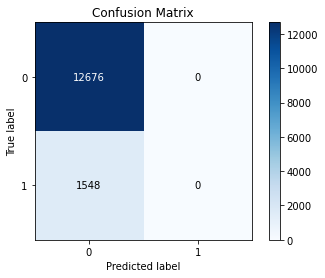

In [295]:
# creazione della pipeline del modello di base DummyClassifier
sa.set_pipeline_steps([DummyClassifier(strategy='most_frequent')])

# valutazione del modello
dummy_res = sa.grid_search_and_evaluate(gs_parameters={})

[DummyClissifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html), impostato con *strategy='most_frequent'* è un modello 'basilare' il cui risultato è rappresentato esclusivamente dalla previsione della label più frequente nel dataset (0 in questo caso).  
Dai risultati della valutazione si può vedere che il modello performa con un'accuratezza del 89%. E' chiaro quindi che questo tipo di metrica non ha un riscontro effettivo sulle reali capacità di previsione in quanto è fortemente soggetta allo sbilanciamento dei dati. Si può inoltre vedere che i valori della metrica F1 sono molto elevati per la label 0 e a zero per la label 1.   

Dopo aver mostrato che l' *accuracy* in questo caso non è una metrica informativa per le performance del modello, si vuole introdurre un approccio più elaborato rappresentato dal modello [MultinomialNaiveBayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html). Si tratta di un modello di classificazione le cui caratteristiche principali sono le seguenti:
* rappresenta il documento come *bag-of-word*: a ciascuna parola del documento è assegnata la propria frequenza al suo interno (la posizione delle parole non è tenuta in considerazione);
* si basa sulla regola di Bayes per associare la probabilità di una certa classe dato un documento;
* il Multinomial Naive Bayes assume inoltre l'indipendenza delle feature (Conditional Independence);
* si tratta di un modello robusto rispetto a features irrilevanti.  

Di seguito è riportato il codice per l'utilizzo del modello MultinomialNB. Come step basilari della pipeline sono presenti :
* [CountVectorizer](https://scikit-learn.org/stable/modules/feature_extraction.html#common-vectorizer-usage): permette di trasformare un corpus di documenti in una matrice in cui ogni riga rappresenta un documento e ciascuna colonna corrisponde ad un certo token (con la relativa frequenza nel documento). Questo processo permette di definire la rappresentazione 'bag-of-word'. Se viene specificato il parametro 'binary=True', allora la frequenza dei termini non è salvata (ma solo la loro presenza nel documento);
* [TfIdfTransformer](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting): (Term Frequency Inverse Document Frequency) esegue una trasformazione assumendo che i termini molto frequenti nel corpus possano offuscare termini più rari ma più rappresentativi.  

Grid-search best score (f1_macro): 0.478
Grid-search best parameters: {}


,0,1,accuracy,macro avg,weighted avg
precision,0.892057,0.681818,0.891732,0.786938,0.869177
recall,0.999448,0.009690,0.891732,0.504569,0.891732
f1-score,0.942704,0.019108,0.891732,0.480906,0.842189
support,12676.000000,1548.000000,0.891732,14224.000000,14224.000000


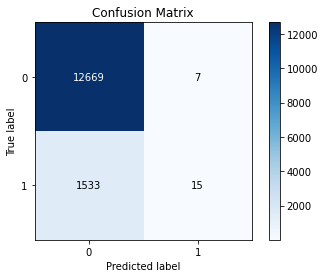

In [296]:
# creazione della pipeline del modello MultinomialNB
sa.set_pipeline_steps([CountVectorizer(),
                       TfidfTransformer(),
                       MultinomialNB(),
                      ])

# valutazione del modello
multinomialNB_res = sa.grid_search_and_evaluate(gs_parameters={})

Come è possibile vedere dai risultati, nonstante il valore di *accuracy* sia comunque elevato, è possibile vedere che, a causa dello sbilanciamento dei dati, il modello non riesce a lavorare bene con i dati di classe 1. Per rimediare a questa problematica è possibile fare ricorso a tecniche di resampling opportune specificando il valore *resampling_strategy* nella funzione *grid_search_and_evaluate()*. Di seguito sono riportati i valori in riferimento alle strategie *SMOTE* (di oversampling) e *RandomUnderSampler*. Se la *SMOTE* permette di generare *nuovi campioni* della classe minoritaria (quindi senza replicazione di sample), il *RandomUnderSampler* consente di selezionare in maniera casuale una porzione di sample della classe maggiortaria in modo tale da creare un dataset bilanciato. (Sono state testati anche diversi valori di *class_prior* del modello ma le metodologie di resampling risultano essere più performanti).

Resampling: SMOTE

Grid-search best score (f1_macro): 0.647
Grid-search best parameters: {}


,0,1,accuracy,macro avg,weighted avg
precision,0.974038,0.308559,0.778895,0.641298,0.901613
recall,0.772483,0.831395,0.778895,0.801939,0.778895
f1-score,0.861631,0.450079,0.778895,0.655855,0.816841
support,12676.000000,1548.000000,0.778895,14224.000000,14224.000000


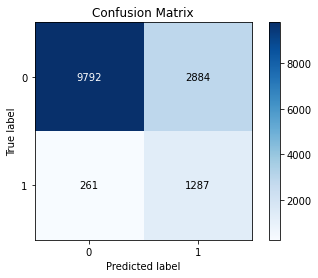


Resampling: RandomUnderSampler

Grid-search best score (f1_macro): 0.58
Grid-search best parameters: {}


,0,1,accuracy,macro avg,weighted avg
precision,0.985864,0.246125,0.683915,0.615994,0.905358
recall,0.654702,0.923127,0.683915,0.788914,0.683915
f1-score,0.786859,0.388632,0.683915,0.587745,0.743520
support,12676.000000,1548.000000,0.683915,14224.000000,14224.000000


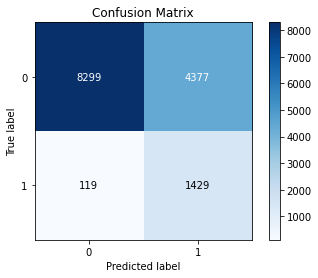

In [297]:
# creazione della pipeline del modello MultinomialNB con rampling a SMOTE
print('Resampling: SMOTE\n')
sa.set_pipeline_steps([CountVectorizer(),
                       TfidfTransformer(),
                       MultinomialNB(),
                      ], resampling_strategy='SMOTE')

# valutazione del modello
multinomialNB_SMOTE_res = sa.grid_search_and_evaluate(gs_parameters={})


# creazione della pipeline del modello MultinomialNB con rampling a RandomUnderSampler
print('\nResampling: RandomUnderSampler\n')
sa.set_pipeline_steps([CountVectorizer(),
                       TfidfTransformer(),
                       MultinomialNB(),
                      ], resampling_strategy='RandomUnderSampler')

# valutazione del modello
multinomialNB_RandomUnderSampler_res = sa.grid_search_and_evaluate(gs_parameters={})

Dai risultati ottenuti è possibile vedere che utlizzando una strategia di resampling a *SMOTE* le performance aumentano sia in termini di *F1_macro* che di *F1* delle singole classi come anche l' *accuracy* generale.  
Considerando quindi questa tipologia di resampling, si vuole adesso effettuare un grid-search dei parametri in modo tale da vedere se è possibile migliorare ulteriormente il modello.  
E' stato deciso di considerare diverse combinazioni di features e parametri tra cui: 
* il parametro *alpha* di MultinomialNB (ovvero il parametro di smoothinig del modello);
* il parametro *binary* del CountVectorizer (per capire se serve utilizzare la frequenza dei termini);
* diversi range di *n-gram* del CountVectorize da considerare come feature;
* il parametro *use_idf* del TfidfTransformer (ovvero se considerare o meno l'Inverse Document Frequency); 

Grid-search best score (f1_macro): 0.686
Grid-search best parameters: {'countvectorizer__binary': True, 'countvectorizer__ngram_range': (1, 2), 'multinomialnb__alpha': 1, 'tfidftransformer__use_idf': True}


,0,1,accuracy,macro avg,weighted avg
precision,0.965724,0.363101,0.829092,0.664412,0.900141
recall,0.837962,0.756460,0.829092,0.797211,0.829092
f1-score,0.897318,0.490677,0.829092,0.693997,0.853063
support,12676.000000,1548.000000,0.829092,14224.000000,14224.000000


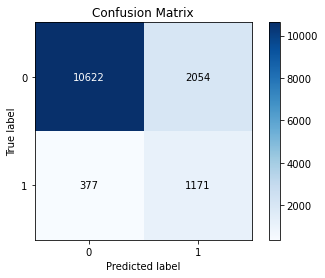

In [298]:
# creazione della pipeline del modello MultinomialNB con resampling a SMOTE
sa.set_pipeline_steps([CountVectorizer(stop_words=sa.stopwords),
                       TfidfTransformer(),
                       MultinomialNB(),
                      ], resampling_strategy='SMOTE')

# settaggio parametri per grid search
parameters_ = {
    'multinomialnb__alpha': (0.5, 1),
    'countvectorizer__binary': (True, False),
    'countvectorizer__ngram_range': [(1,1), (1,2)],
    'tfidftransformer__use_idf': (True, False),
}

multinomialNB_res = sa.grid_search_and_evaluate(gs_parameters=parameters_)

Dai risultati ottenuti dal grid-search, è possibile vedere un miglioramento rispetto alla versione precedente senza tuning dei parametri (con il resampling a *SMOTE*). In particolare infatti si vede un aumento in termini di *F1* (sia macro che riferita a ciascuna classe) ed anche rispetto al valore di *accuracy.*  

Un ulteriore modello di classifiacazione è rappresentato dal [ComplementNaiveBayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html), ovvero una variante del MultinomialNaiveBayes ma più adatto in problemi in cui il dataset è sbilanciato. Il [meccanismo](https://www.geeksforgeeks.org/complement-naive-bayes-cnb-algorithm/) che ne sta alla base si può riassumere brevente nei seguenti passaggi:
* per ogni classe calcola la probabilità che un certo documento NON appartenga ad essa;
* dopo aver calcolato questo valore per ogni classe, è selezionata quella con probabilità MINORE. E' selezionata quindi la classe che ha la probabilità minore che il documento non appartenga ad essa (ovvero la probabilità maggiore che questo appartenga alla classe).  

Di seguito è riportato il codice relativo alla creazione del modello *ComplementNB* (con la relativa grid-search).

Grid-search best score (f1_macro): 0.68
Grid-search best parameters: {'complementnb__alpha': 1, 'complementnb__norm': False, 'countvectorizer__binary': False, 'countvectorizer__ngram_range': (1, 1), 'tfidftransformer__use_idf': False}


,0,1,accuracy,macro avg,weighted avg
precision,0.945693,0.398226,0.8589,0.671960,0.886112
recall,0.892947,0.580103,0.8589,0.736525,0.858900
f1-score,0.918564,0.472259,0.8589,0.695411,0.869992
support,12676.000000,1548.000000,0.8589,14224.000000,14224.000000


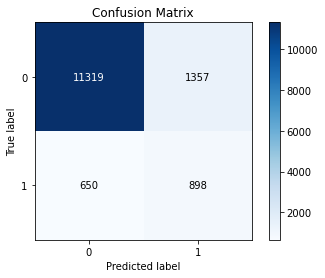

In [299]:
# creazione della pipeline del modello ComplementNB
sa.set_pipeline_steps([CountVectorizer(stop_words=sa.stopwords),
                       TfidfTransformer(),
                       ComplementNB(),
                      ])

# settaggio parametri per grid search
parameters_ = {
    'complementnb__alpha': (0.5, 1),
    'complementnb__norm': (True, False),
    'countvectorizer__binary': (True, False),
    'countvectorizer__ngram_range': [(1,1), (1,2)],
    'tfidftransformer__use_idf': (True, False),
}

complementNB_res = sa.grid_search_and_evaluate(gs_parameters=parameters_)

Dai risultati sopra riportati si può quindi vedere che, anche senza l'utilizzo di tecniche di ricampionamento dei dati, questo modello ha perfomance comparabili al *MultinomialNB* con *SMOTE* (anche se leggermente inferiori in termini di *F1* macro, per classe e *accuracy*).  

Come ultimo modello, è stato considerato il [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) (anche chiamato *logit regression*, *maximum-entropy* o *log-linear classifier*). Si tratta sostanzialmente di un modello di classificazione, il cui funzionamento è paragonabile ad un modello di regressione con la differenza però che l'output è poi processato da una funzione logistica (caso particolare di una sigmoide). Il risultato sarà quindi sempre un valore categorico (0 o 1). Questo algoritmo ha inoltre la caratteristica di essere cost-sensitive, in quanto è possibile specificare un certo peso per ciascuna delle classi presenti nel dataset e quindi risulta essere predisposto in problemi con dati sbilanciati.
Senza entrare nei dettagli specifici, si vuole di seguito riportare il codice relativo all'implementazione del modello LogisticRegression con il relativo grid-search dei parametri megliori.

Grid-search best score (f1_macro): 0.683
Grid-search best parameters: {'countvectorizer__max_df': 0.5, 'logisticregression__C': 1.0, 'logisticregression__class_weight': 'balanced', 'logisticregression__solver': 'newton-cg'}


,0,1,accuracy,macro avg,weighted avg
precision,0.966554,0.357294,0.824733,0.661924,0.900248
recall,0.832124,0.764212,0.824733,0.798168,0.824733
f1-score,0.894315,0.486931,0.824733,0.690623,0.849980
support,12676.000000,1548.000000,0.824733,14224.000000,14224.000000


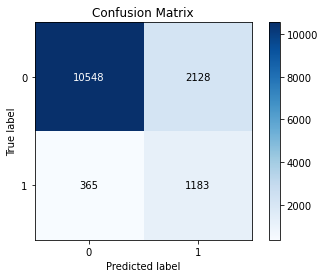

In [300]:
# creazione della pipeline del modello LogisticRegression
sa.set_pipeline_steps([CountVectorizer(stop_words=sa.stopwords, ngram_range=(1,2)),
                       TfidfTransformer(),
                       LogisticRegression(),
                      ])

# settaggio parametri per grid search
parameters_ = {
    'logisticregression__class_weight': (None, 'balanced'),
    'logisticregression__solver': ('newton-cg', 'saga'),
    'logisticregression__C': (0.8, 1.0),
    'countvectorizer__max_df': [0.5, 1],
}

logisticRegression_res = sa.grid_search_and_evaluate(gs_parameters=parameters_)

Come è possibile notare, i valori di *F1* (sia macro che per le classi) sono molto in linea con quelle dei risultati precedenti.

Sulla base dei risultati fino a qui ottenuti, si vuole adesso mettere a confronto in maniera più chiara le perfomance dei diversi modelli considerati in funzione delle metriche: *F1 macro*, *F1* per la classe 0, *F1* per classe 1 e *accurcay* (quest'ultima è visualizzata, ma come detto in precedenza è poco informativa in questo caso).

In [301]:
sa.display_multiple_evaluation({'MNB_Undersamp': multinomialNB_RandomUnderSampler_res['classification_report'],
                                'MNB_SMOTE': multinomialNB_res['classification_report'], 
                                'CNB': complementNB_res['classification_report'],
                                'LR' : logisticRegression_res['classification_report'],
                               }, metric='f1-score', class_ref='macro avg', 
                               bar_color=['rgb(55, 83, 9)', 'rgb(55, 83, 59)', 
                                          'rgb(55, 83, 109)', 'rgb(55, 83, 249)'])

sa.display_multiple_evaluation({'MNB_Undersamp': multinomialNB_RandomUnderSampler_res['classification_report'],
                                'MNB_SMOTE': multinomialNB_res['classification_report'], 
                                'CNB': complementNB_res['classification_report'],
                                'LR' : logisticRegression_res['classification_report'],
                               }, metric='f1-score', class_ref='1', 
                               bar_color=['rgb(55, 83, 9)', 'rgb(55, 83, 59)', 
                                          'rgb(55, 83, 109)', 'rgb(55, 83, 249)'])

sa.display_multiple_evaluation({'MNB_Undersamp': multinomialNB_RandomUnderSampler_res['classification_report'],
                                'MNB_SMOTE': multinomialNB_res['classification_report'], 
                                'CNB': complementNB_res['classification_report'],
                                'LR' : logisticRegression_res['classification_report'],
                               }, metric='f1-score', class_ref='0', 
                               bar_color=['rgb(55, 83, 9)', 'rgb(55, 83, 59)', 
                                          'rgb(55, 83, 109)', 'rgb(55, 83, 249)'])

sa.display_multiple_evaluation({'MNB_Undersamp': multinomialNB_RandomUnderSampler_res['classification_report'],
                                'MNB_SMOTE': multinomialNB_res['classification_report'], 
                                'CNB': complementNB_res['classification_report'],
                                'LR' : logisticRegression_res['classification_report'],
                               }, metric='accuracy', 
                               bar_color=['rgb(55, 83, 9)', 'rgb(55, 83, 59)', 
                                          'rgb(55, 83, 109)', 'rgb(55, 83, 249)'])

Dai risultati ottenuti è quindi possibile vedere che la scelta della metodologia di resampling nel caso del MultinomialNB porta a rilevanti conseguenze (con la *SMOTE* si ottengono performance migliori). Confrontando invece gli altri modelli si può notare che in generale hanno prestazioni molto simili tra loro e per il modello ComplementNB c'è un leggero peggioramento in riferimento alla metrica *F1* per la classe 1 (risposta aperta negativa). E' possibile quindi vedere che se per le risposte positive i modelli riescono a performare in maniera piuttosto efficiente, per quelle negative si riscontrano maggiori problematiche. Oltre alle tecniche di resampling e weighting delle classi, l'utilizzo di metodologie apposite più mirate potrebbero favorire una maggior prestazione generale. Al fine di migliorare i risultati ottenuti potrebbe poi essere possibile l'utilizzo di trasformazioni apposite (ad esempio per la gestione delle negazioni) che però nella lingua italiana trovano una maggiore difficoltà di implementazione.  

Di seguito si vogliono riportare alcuni esempi di previsione del modello MultinomialNB con SMOTE rispetto ad alcune frasi di esempio. E' prima effettuato l'addestramento del modello su tutti i dati disponibili e poi viene chiamata la funzione *predict()* su alcune frasi di prova.

In [315]:
sa.set_pipeline_steps([CountVectorizer(stop_words=sa.stopwords, 
                                       binary=True, 
                                       ngram_range=(1,2)),
                       TfidfTransformer(use_idf=True),
                       MultinomialNB(),
                      ], resampling_strategy='SMOTE')

model = sa.train_all_data()

frasi = ['Banca stupenda e personale sempre disponibile',
         'Che brutta banca personale scorbutico', 
         'Servizio pessimo ma personale disponibile', 
         'non è possibile che esistano ancora banche così arretrate', 
         'non pensavo fosse così efficiente',
         'sicuramente non la consiglio',
         'sicuramente la consiglio',
        ]
txt = pd.Series(frasi)
pred = model.predict(txt)

for index, frase in enumerate(frasi):
    s = 'BUONO' if pred[index]==0 else 'CATTIVO'
    print('Score: {0} , frase: {1}'.format(s, frase))
    
    

Score: BUONO , frase: Banca stupenda e personale sempre disponibile
Score: CATTIVO , frase: Che brutta banca personale scorbutico
Score: CATTIVO , frase: Servizio pessimo ma personale disponibile
Score: CATTIVO , frase: non è possibile che esistano ancora banche così arretrate
Score: BUONO , frase: non pensavo fosse così efficiente
Score: CATTIVO , frase: sicuramente non la consiglio
Score: BUONO , frase: sicuramente la consiglio


### 3.4 Calcolo score finale  

Sulla base dei modelli considerati, si vuole adesso descrivere in che modo questi possono essere utilizzati al fine di migliorare la metodologia di valutazione della soddisfazione dei clienti nella banca.  
Un aspetto che si è notato durante l'esplorazione dei dati è che alcuni questionari che in media hanno un valore di soddisfazione alto, contengono però domande aperte che non sono del tutto positive (magari perchè nel complesso il cliente è soddisfatto ma nelle risposte aperte specifica alcuni suoi malcontenti). In uno scenario di miglioramento del calcolo della soddisfazione, i meccanismi di Sentimen Analysis potrebbero giocare un ruolo importante in questo senso: esaltare clienti soddisfatti (quindi con domande chiuse e risposte aperte effettimente positive), rispetto a quei clienti sì soddisfatti in generale, ma con qualche malcontento espresso nelle domande aperte (e che senza tecniche di rilevamento del sentimento non potrebbero essere rilevati).  

Nel caso in esame però, le label usate per categorizzare le risposte aperte corrispondono al valore delle risposte chiuse del questionario e quindi i modelli addestrati su questa tipologia di dati farebbero fatica ad essere realmenti informativi rispetto al contesto sopra descritto. Una soluzione (non implementata però in questo progetto) potrebbe essere quindi quella di addestrare i modelli sulla base di target diversi dalle risposte chiuse dei questionari.  
Anche nel caso si volessero utilizzare i modelli trovati con quest'ultimo approccio però, ciò che sarebbe davvero utile è la previsione su dati mai visti e non su quelli di train (come sarebbe in questo caso). In altre parole quindi, al fine di utilizzare il risultato della SA per migliorare la metodologia di valutazione, potrebbe essere utile avere un dataset solo per l'addestramento per poi applicare i modelli di previsione sui dati reali (che ad esempio potrebbero essere quelli considerati in questo progetto).  

Per questo motivo è stato deciso di non utilizzare i modelli trovati per calcolare lo score finale, ma è utilizzato solamente il valore delle risposte chiuse. Per ciacun questionario è quindi calcolato uno score di soddisfazione (allo stesso modo in cui la label del testo è creata) ed infine per ciascun utente è calcolata la media dei punteggio riferiti a tutti i questionari compilati.

In [316]:
def transform_for_GA(df):
    """
    A partire dal dataframe df che contiene per ogni riga una certa domanda, questa funzione calcola e ritorna 
    un nuovo dataframe in cui per ciascun cliente è associato lo score di soddisfazione medio (sulla base dei
    diversi questionari compilati).
    
    Params:
        df: dataframe di domande da trasformare;
    
    Return:
        dataframe con due colonne [''ID_CLIENTE', 'SCORE''] predisposto alla Sentiment Analysis
    """
    
    def calcola_label(data):
        """
        In input riceve il dataframe 'data' contenente per ogni riga le domande riferite AD UN SOLO QUESTIONARIO.
        Calcola la media dei punteggi delle risposte chiuse (tramite la mappatura 'map_risposte').
        Parametri:
            data: dataframe in ogni riga corrisponde ad una domanda di UN SOLO QUESTIONARIO

        Return:
            media delle risposte chiuse del questionario
        """
        lista_tipo_risposte = data['TIPO_RISPOSTA'].tolist()
        lista_risposte = data['DESC_RISPOSTA'].tolist()
        lista_domande = data['DESC_DOMANDA'].to_list()

        punteggi = []

        for indice, tipo_risposta in enumerate(lista_tipo_risposte):
            if tipo_risposta == 'inputradio' or tipo_risposta == 'inputmulticheckb':
                risposta = lista_risposte[indice].lower()
                valore_risposta = map_risposte.get(risposta, None)
                if valore_risposta is not None:
                    punteggi.append(valore_risposta)
        
        if punteggi==[]: return np.nan
        return statistics.mean(punteggi)
    
    df_valutato = df.copy()
    df_valutato = df_valutato.groupby(['ID_CLIENTE', 
                                       'ID_QUESTIONARIO',
                                       'ID_SESSIONE_QUESTIONARIO',
                                       'DATA_COMPILAZIONE',
                                       'DESC_QUESTIONARIO']).apply(calcola_label).reset_index(name='SCORE')
    df_valutato = df_valutato.dropna()
    df_valutato = df_valutato.groupby(['ID_CLIENTE']).mean().reset_index()
    df_valutato = df_valutato[['ID_CLIENTE', 'SCORE']]                                                   
    return df_valutato
    

In [329]:
df_score_cliente = transform_for_GA(df_questionari)
print('Dimensione dataframe: \nrighe: {0}, colonne: {1}'.format(df_score_cliente.shape[0], 
                                                                df_score_cliente.shape[1]))
display(df_score_cliente.head(3))

Dimensione dataframe: 
righe: 107357, colonne: 2


,ID_CLIENTE,SCORE
0,6124029,3.4225
1,6124174,3.4150
2,6124554,3.2550


## 4. Graph Analytics  

Come riportato nel paragrafo 2, oltre ai dati riferiti ai questionari compilati, sono presenti anche i dati relativi alle connessioni tra i clienti e le filiali. Grazie quindi a queste informazioni è possibile ricavarne la relativa struttura a grafo sulla quale implementare la parte di Graph Analytics del progetto. Più in particolare si vogliono trattare i seguenti aspetti:
* **Obiettivo 1**: definire una metodologia tramite la quale, a partire da un nodo sorgente (con score), venga calcolata la relativa rete di influenza. Ciascun cliente in questa rete avrà associato un grado influenza che dipenderà dallo score del nodo sorgente e dalla distanza da esso;
* **Obiettivo 2**: implementare un approccio che consenta di ricavare il livello di gradimento delle fialiali in funzione dello score di partenza e del grado di influenza calcolato nel punto precedente.  

Di seguito quindi, la sezione 4.1 si focalizza sulla creazione del grafo a partire dai dati a disposizione, mentre nelle due sezioni successive (4.2 e 4.3) saranno trattati rispettivamente gli obiettivi 1 e 2 sopra descritti.

### 4.1 Creazione del grafo  

In sezione 2.2 è stato caricato il dataframe delle relazioni che mettono in collegamento tra loro i clienti e le rispettive filiali. Di seguito ne sono quindi visualizzate le prime righe ed inoltre sono ricavate alcune informazioni utili sui diversi valori presenti (è già stato visto in sezione 2.2 che non sono presenti valori nulli).

In [328]:
print('Dimensione dataframe, righe: {0}, colonne: {1}'.format(df_relazioni.shape[0], df_relazioni.shape[1]))
display(df_relazioni.head(3))

print('\nNumero clienti: {}'.format(len(set(list(df_relazioni['ID_CLIENTE_1'].unique())+\
                                            list(df_relazioni['ID_CLIENTE_2'].unique())))
                                   ))
print('Numero cod. natura giuridca: {}'.format(len(set(list(df_relazioni['COD_NATURA_GIURIDICA_1'].unique())+\
                                                       list(df_relazioni['COD_NATURA_GIURIDICA_2'].unique())))
                                              ))
print('Numero filiali: {}'.format(len(set(list(df_relazioni['ID_FILIALE_1'].unique())+\
                                          list(df_relazioni['ID_FILIALE_2'].unique())))
                                 ))
print('Numero cod collegamenti: {}'.format(len(list(df_relazioni['COD_COLLEGAMENTO'].unique()))))
      

Dimensione dataframe, righe: 4089536, colonne: 8


,ID_CLIENTE_1,COD_NATURA_GIURIDICA_1,ID_FILIALE_1,COD_COLLEGAMENTO,DESC_COLLEGAMENTO,ID_CLIENTE_2,COD_NATURA_GIURIDICA_2,ID_FILIALE_2
0,6123972,DI,28438,R01,TIT. DITTA INDIV.,6482323,PF,28438
1,6123981,DI,28638,R01,TIT. DITTA INDIV.,6173394,PF,28638
2,6123989,PF,45955,I85,HA COME EREDE,6756182,PF,45955



Numero clienti: 3505346
Numero cod. natura giuridca: 3
Numero filiali: 1660
Numero cod collegamenti: 61


A questo punto, essendo che è necessario unire le informazioni delle relazioni con lo score dei clienti, di seguito è riportato il codice che assegna per ogni *ID_CLIENTE_1* e *ID_CLIENTE_2* il relativo score memorizzato nel dataframe *df_score_cliente* (per quei clienti di cui non ho uno score, assegno il valore -1).

In [335]:
df_scored_1 = df_score_cliente.rename(columns={'ID_CLIENTE': 'ID_CLIENTE_1', 'SCORE': 'SCORE_1'})
df_relazioni_scored = df_relazioni.merge(df_scored_1, on='ID_CLIENTE_1', how='left')

df_scored_2 = df_score_cliente.rename(columns={'ID_CLIENTE': 'ID_CLIENTE_2', 'SCORE': 'SCORE_2'})
df_relazioni_scored = df_relazioni_scored.merge(df_scored_2, on='ID_CLIENTE_2', how='left')

df_relazioni_scored = df_relazioni_scored.fillna(-1)

print('Dimensione: righe: {0}, colonne: {1}'.format(df_relazioni_scored.shape[0], 
                                                      df_relazioni_scored.shape[1]))
display(df_relazioni_scored.head(3))

clienti_1_scored = list(df_relazioni_scored[df_relazioni_scored['SCORE_1']!=-1]['ID_CLIENTE_1'].unique())
clienti_2_scored = list(df_relazioni_scored[df_relazioni_scored['SCORE_2']!=-1]['ID_CLIENTE_2'].unique())
print('Numero di clienti con score {}'.format(len(set(clienti_1_scored+clienti_2_scored))))

Dimensione: righe: 4089536, colonne: 10


,ID_CLIENTE_1,COD_NATURA_GIURIDICA_1,ID_FILIALE_1,COD_COLLEGAMENTO,DESC_COLLEGAMENTO,ID_CLIENTE_2,COD_NATURA_GIURIDICA_2,ID_FILIALE_2,SCORE_1,SCORE_2
0,6123972,DI,28438,R01,TIT. DITTA INDIV.,6482323,PF,28438,-1.0,-1.0
1,6123981,DI,28638,R01,TIT. DITTA INDIV.,6173394,PF,28638,-1.0,-1.0
2,6123989,PF,45955,I85,HA COME EREDE,6756182,PF,45955,-1.0,-1.0


Numero di clienti con score 65751


Una volta associato lo score a ciascun cliente, per poter caricare i dati in neo4j è stato deciso di utilizzare la funzionalità di [neo4j-admin import](https://neo4j.com/docs/operations-manual/current/tutorial/neo4j-admin-import/) dal momento che questo approccio risulta essere performante per il caricamento di un quantitativo di dati elevato. In particolare quindi, sono stati creati 4 file csv con le relative caratteristiche:
* **dataset/graph/clienti.csv**: contiene le informazioni relative ai nodi clienti del grafo. Il relativo header è nella seguente forma: **cliente_id:ID,natura_giuridica,score:float,:LABEL**;
* **dataset/graph/relazioni_clienti.csv**: contiene le informazioni relative alle relazioni tra i clienti ed ha un header composto nel seguente modo: **:START_ID,descrizione,codice,:END_ID,:TYPE**, in cui *:START_ID* e *END_ID* si riferiscono ad un certo *cliente_id* del file *clienti.csv*;
* **dataset/graph/filiali.csv**: continene le informazioni delle filiali e il relativo header è nella seguente forma: **filiale_id:ID,:LABEL**;
* **dataset/graph/relazioni_clienti_filiali.csv**: continene le informazioni relative alle relazioni che i clienti hanno con le filiali ed ha un header della seguente forma: **:START_ID,:END_ID,:TYPE**

Di seguito è riportato il codice relativo alla creazione dei due file sopra descritti.

In [344]:
# creazione del file 'dataset/graph/clienti.csv'
df_clienti_1 = df_relazioni_scored[['ID_CLIENTE_1', 'COD_NATURA_GIURIDICA_1', 'SCORE_1']].drop_duplicates()
df_clienti_1 = df_clienti_1.rename(columns={'ID_CLIENTE_1': 'cliente_id:ID', 
                                            'COD_NATURA_GIURIDICA_1': 'natura_giuridica', 'SCORE_1': 'score:float'
                                           })
df_clienti_2 = df_relazioni_scored[['ID_CLIENTE_2', 'COD_NATURA_GIURIDICA_2', 'SCORE_2']].drop_duplicates()
df_clienti_2 = df_clienti_2.rename(columns={'ID_CLIENTE_2': 'cliente_id:ID', 
                                            'COD_NATURA_GIURIDICA_2': 'natura_giuridica', 'SCORE_2': 'score:float'
                                           })
df_clienti_1_2 = pd.concat([df_clienti_1,df_clienti_2]).drop_duplicates().reset_index(drop=True)
df_clienti_1_2[':LABEL'] = 'CLIENTE'
print('Numero clienti nel file dataset/graph/clienti.csv: {}'.format(df_clienti_1_2.shape[0]))
df_clienti_1_2.to_csv('./dataset/graph/clienti.csv', index=False, header=True)


# creazione del file dataset/graph/relazioni.csv
df_rel = df_relazioni_scored[['ID_CLIENTE_1', 'DESC_COLLEGAMENTO', 'COD_COLLEGAMENTO', 'ID_CLIENTE_2']]
df_rel = df_rel.rename(columns={'ID_CLIENTE_1': ':START_ID', 'DESC_COLLEGAMENTO': 'descrizione', 
                                'COD_COLLEGAMENTO': 'codice', 'ID_CLIENTE_2': ':END_ID'})
df_rel[':TYPE'] = 'CONNESSO_A'
print('Numero relazioni nel file dataset/graph/relazioni.csv: {}'.format(df_rel.shape[0]))
df_rel.to_csv('./dataset/graph/relazioni_clienti.csv', index=False, header=True)


# creazione del file dataset/graph/filiali.csv
df_filiali_1 = df_relazioni_scored[['ID_FILIALE_1']].drop_duplicates()
df_filiali_1 = df_filiali_1.rename(columns={'ID_FILIALE_1': 'filiale_id:ID'})
df_filiali_2 = df_relazioni_scored[['ID_FILIALE_2']].drop_duplicates()
df_filiali_2 = df_filiali_2.rename(columns={'ID_FILIALE_2': 'filiale_id:ID'})
df_filiali_1_2 = pd.concat([df_filiali_1,df_filiali_2]).drop_duplicates().reset_index(drop=True)
df_filiali_1_2[':LABEL'] = 'FILIALE'
print('Numero filiali nel file dataset/graph/filiali.csv: {}'.format(df_filiali_1_2.shape[0]))
df_filiali_1_2.to_csv('./dataset/graph/filiali.csv', index=False, header=True)


# creazione del file dataset/graph/relazioni_filiali.csv
df_rel_filiali_1 = df_relazioni_scored[['ID_CLIENTE_1', 'ID_FILIALE_1']].drop_duplicates()
df_rel_filiali_1 = df_rel_filiali_1.rename(columns={'ID_CLIENTE_1': ':START_ID', 'ID_FILIALE_1': ':END_ID'})
df_rel_filiali_2 = df_relazioni_scored[['ID_CLIENTE_2', 'ID_FILIALE_2']].drop_duplicates()
df_rel_filiali_2 = df_rel_filiali_2.rename(columns={'ID_CLIENTE_2': ':START_ID', 'ID_FILIALE_2': ':END_ID'})
df_rel_filiali_1_2 = pd.concat([df_rel_filiali_1,df_rel_filiali_2]).drop_duplicates().reset_index(drop=True)
df_rel_filiali_1_2[':TYPE'] = 'CLIENTE_DI'
print('Numero relazioni nel file dataset/graph/relazioni_clienti_filiali.csv: {}'\
      .format(df_rel_filiali_1_2.shape[0]))
df_rel_filiali_1_2.to_csv('./dataset/graph/relazioni_clienti_filiali.csv', index=False, header=True)

Numero clienti nel file dataset/graph/clienti.csv: 3505346
Numero relazioni nel file dataset/graph/relazioni.csv: 4089536
Numero filiali nel file dataset/graph/filiali.csv: 1660
Numero relazioni nel file dataset/graph/relazioni_clienti_filiali.csv: 3505346


In [345]:
! head -n 5 ./dataset/graph/clienti.csv

cliente_id:ID,natura_giuridica,score:float,:LABEL
6123972,DI,-1.0,CLIENTE
6123981,DI,-1.0,CLIENTE
6123989,PF,-1.0,CLIENTE
6124027,PF,-1.0,CLIENTE


In [346]:
! head -n 5 ./dataset/graph/relazioni_clienti.csv

:START_ID,descrizione,codice,:END_ID,:TYPE
6123972,TIT. DITTA INDIV.,R01,6482323,CONNESSO_A
6123981,TIT. DITTA INDIV.,R01,6173394,CONNESSO_A
6123989,HA COME EREDE,I85,6756182,CONNESSO_A
6124027,HA COME EREDE,I85,6711749,CONNESSO_A


In [347]:
! head -n 5 ./dataset/graph/filiali.csv

filiale_id:ID,:LABEL
28438,FILIALE
28638,FILIALE
45955,FILIALE
45854,FILIALE


In [348]:
! head -n 5 ./dataset/graph/relazioni_clienti_filiali.csv

:START_ID,:END_ID,:TYPE
6123972,28438,CLIENTE_DI
6123981,28638,CLIENTE_DI
6123989,45955,CLIENTE_DI
6124027,45854,CLIENTE_DI


I file csv così creati corrispondono alla struttura del grafo che si vuole creare. Per poter utilizzarli in neo4j, è stata utilizzata la versione neo4j Desktop e, dopo aver creato un nuovo progetto chiamato *University*, è stato istanziato un nuovo *Local DBMS* di nome *uni_graph_analytics* con versione 4.4.3 di neo4j, in cui sono installati i plugin *APOC* (v. 4.4.0.2) e *Graph Data Science Library* (v. 1.8.2) tramite l'apposito tab *Plugins*.  

<img src='./img/neo4j_local_dbms.png' width=700>  

Dopo aver copiato i file csv creati nella folder *import* del dbms, è stato eseguito, tramite il *Neo4j Desktop Terminal* il relativo comando *neo4j-admin* per importare i file desiderati.  

<img src='./img/neo4j_admin.png' width=700>  

<img src='./img/neo4j_admin_result.png' width=200>  

I dati sono stati quindi caricati correttamente e nell'ultima immagine sono riportate le statistiche generali della fase di importazione. Di seguito è quindi rappresentato lo schema generale del database a grafo così creato.  

<img src='./img/neo4j_schema.png' width=500>  

Al fine di comunicare con neo4j tramite il linguaggio Python è utilizzata la libreria [py2neo](https://py2neo.org/2021.1/index.html) che permette di connettersi al database appena creato nel seguente modo.

In [424]:
graph = Graph('bolt://localhost:7687', auth=('neo4j', 'uni_graph_analytics'))

### 4.2 Obiettivo 1  

Il primo obiettivo che ci si è posti riguarda la determinazione delle reti di influenza in funzione di un certo nodo sorgente (con score) e l'assegnazione di uno specifico grado di influenza ai nodi appartenenti a questa rete. Nel dettaglio quindi si vuole :
* studiare una metodologia che permetta di ricavare una rete di influenza a partire da un certo nodo;
* assegnare un livello di influenza a tutti nodi della rete di influenza tenendo conto sia dello score iniziale del nodo sorgente che dalla distanza che ciascuno ha in riferimento a quest'ultimo.  

Di seguito sono quindi presenti due sotto-sezioni in cui la prima corrisponde alla *development-phase* in cui è analizzato l'approccio utilizzato per la risoluzione del problema, la seconda rappresenta invece l' *implementation-phase* in cui è calcolata la rete di influenza per i primi 3 clienti più soddisfatti e insoddisfatti.  

#### 4.2.1 Development-phase  

Al fine di ricavare una rete di influenza a partire da un certo nodo, risulta necessario definire che cosa si intende per rete di influenza. Sulla base dei dati del grafo, è possibile per prima cosa vedere che per questo primo punto ciò che realmente interessa sono le relazioni che intercorrono tra i clienti e non quelle tra cliente e filiale. Sulla base di questi collegamenti, è possibile definire una rete di influenza in funzione di un nodo sorgente come *il sottografo composto dai nodi raggiungibili da quello sorgente*. Sulla base di questa rete di influenza è poi necessario associare a ciascun nodo un valore di *influenza* che dipende dallo score del nodo sorgente e dalla distanza dallo stesso.  

Per il calcolo della rete di influenza è possibile pensare all'utilizzo di algoritmi di *Path Finding* e più in particolare un candidato potrebbe essere l'algoritmo di [Dijkstra](https://neo4j.com/docs/graph-data-science/current/algorithms/dijkstra-single-source/). Si tratta sostanzialmente di un algoritmo che, dato un nodo di partenza, trova il shortest path in riferimento a tutti i nodi raggiungibili. Essendo che in questo caso non sono presenti pesi negli archi, il percorso minimo calcolato è in termini di numero di archi. L'output atteso è quindi una tabella contenente, per ogni nodo raggiungibile, il relativo numero minimo *d* di archi che lo distanziano dal nodo sorgente. Per ciascuno di questi nodi è poi necessario calcolare il grado di influenza *i* il quale dipende sia dallo score del nodo sorgente che dal relativo valore *d.*  
La formula proposta per il calcolo dell'influenza *i* relativa allo score *s* del nodo sorgente è riportata di seguito:

<h3><center> $i = \frac{s-2.5}{d}$ </center></h3>

Lo score iniziale *s* del nodo sorgente ha valori che variano nell'intervallo \[0,5\], in cui 0 indica un grado di soddisfazione molto basso, mentre 5 un grado di soddisfazione molto alto. Un primo approccio considerato per il calcolo di *i* è stato il seguente : 

<h3><center> $i = \frac{s}{d}$</center></h3>

Con questa formulazione si ottiene il seguente comportamento: partendo da un nodo sorgente con *s=4.5* (ad esempio), si ha che per i nodi della rispettiva rete di influenza molto distanti da quello sorgente (es. *d=20*), il valore *i* di influenza tende a zero. Allo stesso modo però, se il nodo sorgente avesse *s=0.5*, all'aumentare della distanza il valore *i* tenderebbe ugualmente a zero. Il problema con questo approccio quindi è che non si hanno distinzioni tra influenze positive e influenze negative. Per modellare meglio questa problematica è stato quindi sottrato ad *s* il valore medio del suo range (vedi formula 1), in modo tale che:
* nel caso di *s* alto (vicino a 5): genera un valore **positivo** che tende a zero per i nodi lontani da quello sorgente;
* nel caso di *s* basso (vicino a 0): genera un valore **negativo** che tende a zero per i nodi lontani da quello sorgente.  

In generale quindi, il segno di *i* indica la positività o negatività dell'influenza, mentre il valore assoluto (che varia nel range \[0,2.5\]) corrisponde al relativo grado (es. *i=+-2.4* indica una forte influenza positiva (o negativa), *i=+-0.5* indica un'influenza debole (positiva o negativa)).  

Un ulteriore aspetto da valutare in relazione a questo primo obiettivo riguarda l'orientamento degli archi. Se in partenza il grafo è definito da archi orientati, la metodologia con cui è ricavata la rete di influenza potrebbe non essere adatta nei casi in cui, ad esempio, un nodo sorgente ha molti archi entranti ma nessuno uscente. In questo caso si otterrebbe una rete di influenza vuota quando nella realtà questo nodo potrebbe influenzare i relativi vicini. Per fronteggiare questa problematica è stato scelto, in fase di creazione della proiezione del grafo, di utilizzare un'orientazione di tipo *UNDIRECTED.*  

Come accennato all'inizio di questo paragrafo, per poter calcolare la rete di influenza rispetto ad un nodo sorgente è possibile utilizzare algoritmi di *Path Find*. In particolare sono stati scelti due approcci: l'utilizzo del [Breath First Search](https://aquarchitect.github.io/swift-algorithm-club/Shortest%20Path%20%28Unweighted%29/) e di [Dijkstra](https://neo4j.com/docs/graph-data-science/current/algorithms/dijkstra-single-source/).  
L'[algoritmo](https://www.edureka.co/blog/breadth-first-search-algorithm/) Breath First Search definisce in sostanza una metodologia tramite la quale esplorare dati modellati come grafi o alberi. Partendo da un nodo sorgente esplora per prima i nodi ad esso collegati e nelle iterazioni successive visiterà le relative connessioni indirette incrementando gradualmente il livello di profondità. Così facendo quindi si ottiene in output una struttura ad albero in cui, partendo dalla radice (ovvero il nodo sorgente dato in input all'algoritmo), è possibile ricavare la distanza (in termini di numero di archi) a qualsiasi altro nodo ad esso collegato. Lo pseudo codice dell'algoritmo è riportato di seguito.  

<img src='./img/bfs_source.png' width=300>

Come si può vedere, fino a che la coda non è vuota avviene: 1) il *dequeue* di un nodo *n*, 2) l'*enqueue* di tutti i nodi vicini *n* non ancora visitati , 3) *n* è marcato come *visitato*.  
Questa metodologia risulta quindi essere adatta per il rilevamento della rete di influenza in riferimento ad un certo nodo sorgente. Sulla base dell'implementazione di questo algoritmo nella libreria Graph Data Scienece di neo4j, è possibile settare alcuni parametri di arresto ed in particolare è possibile definire una profondità massima, superata la quale l'algoritmo si arresta. Questa funzionalità, oltre a portare benefici in termini di efficienza, potrebbe essere di aiuto per il problema in esame in quanto limiterebbe la profondità delle reti di influenza (dopo una certa distanza *n* non ha più senso considerare l'influenza del nodo sorgente).

L'algoritmo di Dijkstra (ed in particolare nella versione Single Source) è caratterizzato da un approccio greedy tramite il quale è possibile, a partire da un nodo sorgente, trovare il shortest path che collega quest'ultimo a tutti gli altri nodi della rete. E' possibile utilizzare questo algoritmo sia per grafi direzionati che non direzionati e lo pseudo-codice risulta il seguente:  

<img src='./img/dijkstra.png' width=500>  

L'idea di base dell'algoritmo quindi, consiste nell'aggiornare continuamente (fino a che la coda non è vuota) la distanza dei nodi rispetto a quello di partenza, ovvero aggiornare *dist\[v\]* nel caso in cui convenga passare per *v* tramite *u* (usando la relazione *(u,v)* di peso *dist_between(u,v)*). In riferimento all'implementazione presente nella libreria Graph Data Science di neo4j, è possibile eseguire l'algoritmo senza specificare i pesi nelle relazioni e così facendo questo approccio risulta essere un'ulteriore alternativa per ricavare la rete di influenza di un certo nodo sorgente.

Per poter mettere in pratica ciò che è stato spiegato è utilizzata la [Graph Data Science Library](https://neo4j.com/docs/graph-data-science/current/) di neo4j. Per prima cosa è stato applicato il [Memory Estimation](https://neo4j.com/docs/graph-data-science/current/common-usage/memory-estimation/#estimate-procedure-graph) rispetto alla creazione della proiezione del grafo tramite [Native Projection](https://neo4j.com/docs/graph-data-science/current/graph-create/) (si vogliono utilizzare relazioni non direzionate).

In [350]:
query = """
CALL gds.graph.create.estimate(
  'CLIENTE',
  {
    CONNESSO_A:{
      type: 'CONNESSO_A',
      orientation: 'UNDIRECTED'
    }
  }
)
YIELD
  requiredMemory, bytesMin, bytesMax, heapPercentageMin, heapPercentageMax
"""
display(graph.run(query).to_data_frame())

,requiredMemory,bytesMin,bytesMax,heapPercentageMin,heapPercentageMax
0,[107 MiB ... 120 MiB],112779936,126708056,0.2,0.2


Dai risultati del Memory Estimate si può vedere che la memoria necessaria per la creazione della proiezione è tra i 107 e i 120 MB, quindi il sistema risulta in grado di supportare questo tipo di operazione.  

La creazione effettiva della proiezione è la seguente.

In [412]:
query = """
CALL gds.graph.create(
  'grafo_clienti_non_direzionato',
  'CLIENTE',
  {
    CONNESSO_A:{
      type: 'CONNESSO_A',
      orientation: 'UNDIRECTED'
    }
  }
)
YIELD
  graphName AS graph,
  relationshipProjection AS knowsProjection,
  nodeCount AS nodes,
  relationshipCount AS rels
"""
display(graph.run(query).to_data_frame())

,graph,knowsProjection,nodes,rels
0,grafo_clienti_non_direzionato,"{'CONNESSO_A': {'orientation': 'UNDIRECTED', '...",3505346,8179072


Oltre per la creazione della proiezione, si vuole adesso effettuare la Memory Estimation per entrambi gli algoritmi considerati (*Breath First Search* e *Dijkstra*). In accordo con la [documentazione](https://neo4j.com/docs/graph-data-science/current/operations-reference/algorithm-references/#alpha-tier) però, il *BFS* fa parte del tier Alpha e non contiene la funzionalità *estimate*. Di seguito è quindi riportata la stima solo in riferimento a *Dijkstra*. 

In [355]:
query = """
MATCH (source:CLIENTE {cliente_id: '8611018'})
CALL gds.allShortestPaths.dijkstra.stream.estimate(
    'grafo_clienti_non_direzionato', 
    {sourceNode: source}
)
YIELD requiredMemory, bytesMin, bytesMax, heapPercentageMin, heapPercentageMax
RETURN requiredMemory, bytesMin, bytesMax, heapPercentageMin, heapPercentageMax
"""
display(graph.run(query).to_data_frame())

,requiredMemory,bytesMin,bytesMax,heapPercentageMin,heapPercentageMax
0,107 MiB,113048136,113048136,0.2,0.2


Anche in questo caso si può quindi vedere che la memoria necessaria per l'esecuzione dell'algoritmo è intorno ai 107 MB e quindi il sistema è in grado di gestirlo.

#### 4.2.2 Implementation-phase   

In questa sezione sono riportati i risultati relativi all'utilizzo dei due algoritmi sopra descritti al fine di definire la rete di influenza per il 3 clienti più soddisfatti e meno soddisfatti. Riguardo alla determinazione dei relativi nodi, dai risulti dei questionari è possibile vedere che sono presenti molteplici clienti con voto 5 (pienamente soddisfatti) e con 0 (completamente insoddisfatti) rendendo così difficile definire quali tra questi lo sono di più di altri. Al fine di ottenere risultati più interessanti, è stato deciso di riportare le reti di influenza dei primi 3 clienti maggiormente soddisfatti e insoddisfatti con il maggior numero di relazioni.

**BREATH FIRST SEARCH**  

Di seguito sono riportati i risultati dell'algoritmo *Breath First Search*.

In [374]:
query = """
MATCH (c:CLIENTE{score: 5})-[r]-(:CLIENTE)
WITH c, COUNT(r) AS num_rel
ORDER BY num_rel DESC LIMIT 3
CALL gds.alpha.bfs.stream(
    'grafo_clienti_non_direzionato', 
    {
     startNode: id(c),
     maxDepth: 3
    }
)
YIELD path
RETURN c.cliente_id AS cliente_id, length(path) AS n_nodi_influenza
"""
display(graph.run(query).to_data_frame())

,cliente_id,n_nodi_influenza
0,6844107,65
1,8179779,103
2,10627251,63


Visualmente (da neo4j Desktop) le reti di influenza con l'algoritmo *Breath First Search* **per i 3 clienti più soddisfatti** risultano essere le seguenti.  

<img src='./img/bfs_soddisf_3.png' width=700>  

E' però importante notare che il risultato ottenuto è riferito all'algoritmo *BFS* con il parametro **maxDepth=3**. Per modellare il problema in esame infatti, si suppone che le reti di influenza siano composte da nodi distanti al massimo 3 dal nodo sorgente (in quanto si assume che gli effetti più rilevanti dell'influenza non superino questo livello di profondità).  

Di seguito è riportato (sempre per l'algoritmo *Breath First Search*) il codice per la determinazione delle reti di influenza in riferimento ai 3 clienti meno soddisfatti.

In [373]:
query = """
MATCH (c:CLIENTE{score: 0})-[r]-(:CLIENTE)
WITH c, COUNT(r) AS num_rel
ORDER BY num_rel DESC LIMIT 3
CALL gds.alpha.bfs.stream(
    'grafo_clienti_non_direzionato', 
    {
     startNode: id(c),
     maxDepth: 3
    }
)
YIELD path
RETURN c.cliente_id AS cliente_id, length(path) AS n_nodi_influenza
"""
display(graph.run(query).to_data_frame())

,cliente_id,n_nodi_influenza
0,22920634,18
1,8409919,8
2,10091630,14


Da neo4j Desktop, i risultati relativi alle reti di influenza dei 3 clienti meno soddisfatti sono i seguenti.  

<img src='./img/bfs_non_soddisf_3.png' width=700 />  

**DIJKSTRA**  

Come fatto per l'algoritmo *BFS*, si vuole di seguito riportare le **reti di influenza dei 3 clienti più soddisfatti** e meno soddisfatti trovati con Dijkstra.

In [372]:
query = """
MATCH (c:CLIENTE{score: 5})-[r]-(:CLIENTE)
WITH c, COUNT(r) AS num_rel
ORDER BY num_rel DESC LIMIT 3
CALL gds.allShortestPaths.dijkstra.stream(
    'grafo_clienti_non_direzionato', 
    {sourceNode: c}
)
YIELD targetNode, totalCost AS distance
WITH c, gds.util.asNode(targetNode) AS target, distance
WHERE distance < 4
RETURN c.cliente_id AS cliente_id, COUNT(target)-1 AS n_nodi_influenza
"""
display(graph.run(query).to_data_frame())

,cliente_id,n_nodi_influenza
0,6844107,65
1,8179779,103
2,10627251,63


Come si può vedere dalla tabella risultante, il numero di nodi di influenza che l'algoritmo di Dijkstra ha trovato per ciascun cliente sorgente, combacia esattamente con quelli trovati tramite il Breath First Search (per questo motivo non è riportata la rete di influenza visualmente). Da notare che se per il BFS è presente la funzione *maxDepth* per definire una profondità massima, con Dijkstra questa funzionalità non è presente e quindi risulta necessario filtrare i valori di distanza una volta che l'algoritmo è terminato.  

Di seguito è riportato il codice per determinare la **rete di influenza dei 3 clienti meno soddisfatti** con l'algoritmo di Dijkstra.

In [371]:
query = """
MATCH (c:CLIENTE{score: 0})-[r]-(:CLIENTE)
WITH c, COUNT(r) AS num_rel
ORDER BY num_rel DESC LIMIT 3
CALL gds.allShortestPaths.dijkstra.stream(
    'grafo_clienti_non_direzionato', 
    {sourceNode: c}
)
YIELD targetNode, totalCost AS distance
WITH c, gds.util.asNode(targetNode) AS target, distance
WHERE distance < 4
RETURN c.cliente_id AS cliente_id, COUNT(target)-1 AS n_nodi_influenza
"""
display(graph.run(query).to_data_frame())

,cliente_id,n_nodi_influenza
0,22920634,18
1,8409919,8
2,10091630,14


Anche in questo caso si può vedere che i risultati ottenuti combaciano con quelli del BFS e per lo stesso motivo accennato prima non è riportata l'immagine della rete di influenza.  

Sulla base dei risultati fino a qui ottenuti, è adesso necessario associare a ciasun nodo di un certo sotto-grafo il relativo valore di influenza utilizzando la formula descritta in sezione 4.2.1. Essendo necessario l'utilizzo del valore di distanza rispetto al nodo sorgente, in accordo alla documentazione, l'algoritmo che risulta più adatto è Dijkstra in quanto tra i diversi parametri che ritorna è presente anche il valore *totalCost*, ovvero la distanza in termini di numeri di archi (dal momento che le relazioni non sono pesate). Con il BFS invece sarebbero necessarie computazioni aggiuntive in quanto i possibili parametri di ritorno sono *startNodeId*, *nodesId* e *path*, senza ritornare esplicitamente un valore di distanza.  

Di seguito è quindi riportato il codice per la creazione della rete di influenza (utilizzando come cliente di esempio quello con *cliente_id=22920634* molto insoddisfatto) e per ciascun nodo in essa presente è associato il relativo valore di influenza.

In [380]:
query = """
MATCH (source:CLIENTE {cliente_id: '22920634'})
CALL gds.allShortestPaths.dijkstra.stream(
    'grafo_clienti_non_direzionato', 
    {sourceNode: source}
)
YIELD targetNode, totalCost AS distance
WITH source, gds.util.asNode(targetNode) AS target, distance
WHERE source.cliente_id <> target.cliente_id AND
      distance < 4
RETURN
    source.cliente_id AS source_id,
    source.score AS source_score,
    target.cliente_id AS target_id,
    (source.score - 2.5) / distance AS influence,
    distance
ORDER BY influence
"""
display(graph.run(query).to_data_frame())

,source_id,source_score,target_id,influence,distance
0,22920634,0.0,22964335,-2.500000,1.0
1,22920634,0.0,22990500,-2.500000,1.0
2,22920634,0.0,22918214,-2.500000,1.0
3,22920634,0.0,22914900,-2.500000,1.0
4,22920634,0.0,24381321,-2.500000,1.0
5,22920634,0.0,24256207,-2.500000,1.0
6,22920634,0.0,24213226,-2.500000,1.0
7,22920634,0.0,22988069,-2.500000,1.0
8,22920634,0.0,23035519,-2.500000,1.0
9,22920634,0.0,23172494,-2.500000,1.0


Dal dataframe così ottenuto è possibile vedere che tutti i nodi collegati direttamente con il nodo sorgente (distanza=1) hanno un valore di influenza massimo negativo (-2.5), mentre all'aumentare della distanza questo valore tende a zero (restando comunque negativo) così da indicare un'influenza meno marcata.  
Lo stesso comportamento (ma in positivo) è possibile vederlo per un cliente molto soddisfatto (ad esempio quello con *cliente_id=6844107*).

In [382]:
query = """
MATCH (source:CLIENTE {cliente_id: '6844107'})
CALL gds.allShortestPaths.dijkstra.stream(
    'grafo_clienti_non_direzionato', 
    {sourceNode: source}
)
YIELD targetNode, totalCost AS distance
WITH source, gds.util.asNode(targetNode) AS target, distance
WHERE source.cliente_id <> target.cliente_id AND
      distance < 4
RETURN
    source.cliente_id AS source_id,
    source.score AS source_score,
    target.cliente_id AS target_id,
    (source.score - 2.5) / distance AS influence,
    distance
ORDER BY influence DESC
"""
display(graph.run(query).to_data_frame())

,source_id,source_score,target_id,influence,distance
0,6844107,5.0,6354105,2.500000,1.0
1,6844107,5.0,13607445,2.500000,1.0
2,6844107,5.0,15262965,2.500000,1.0
3,6844107,5.0,15192008,2.500000,1.0
4,6844107,5.0,15191922,2.500000,1.0
...,...,...,...,...,...
60,6844107,5.0,7712902,0.833333,3.0
61,6844107,5.0,6921669,0.833333,3.0
62,6844107,5.0,22447494,0.833333,3.0
63,6844107,5.0,16815249,0.833333,3.0


Una volta mostrato l'approccio utilizzato per questo primo obiettivo, è possibile eliminare la proiezione del grafo così da liberare memoria per le query successive.

In [416]:
graph.run("""CALL gds.graph.drop('grafo_clienti_non_direzionato')""")

graphName,database,memoryUsage,sizeInBytes,nodeProjection,relationshipProjection,nodeQuery,relationshipQuery,nodeCount,relationshipCount,nodeFilter,relationshipFilter,density,creationTime,modificationTime,schema
grafo_clienti_non_direzionato,neo4j,,-1,"{CLIENTE: {label: 'CLIENTE', properties: {}}}","{CONNESSO_A: {orientation: 'UNDIRECTED', aggregation: 'DEFAULT', type: 'CONNESSO_A', properties: {}}}",null,null,3505346,8179072,null,null,6.656445354755968e-07,datetime('2022-01-20T02:34:06.470641000+01:00'),datetime('2022-01-20T02:34:10.458716000+01:00'),"{relationships: {CONNESSO_A: {}}, nodes: {CLIENTE: {}}}"


### 4.3 Obiettivo-2  

Il secondo obiettivo della parte di Graph Analytics riguarda la determinazione di un opportuno meccanismo mediante il quale quantificare il grado di soddisfazione per ogni filiale tenendo in considerazione sia lo score iniziale dei clienti che il grado di influenza introdotto in sezione 4.2. A questo proposito sono presenti di seguito due sotto-sezioni mirate prima a descrivere in maniera teorica l'approccio utilizzato, per poi (nella fase di implementazione) mostrare in che modo le tecniche considerate possono essere applicate nel caso in esame.  

#### 4.3.1 Development-Phase  

In questa sotto-sezione si vuole descrivere l'approccio utilizzato al fine di riuscire a determinare il grado di soddisfazione di ogni filiale sulla base dello score iniziale dei clienti ed in relazione al grado di influenza trovato.  

La logica seguita può essere schematizzata nei seguenti punti:
* trovare in tutto il grafo i nodi più centrali e selezionarne un certo numero n (sono state pensati **due possibili approcci** per questa prima fase);
* tra questi n nodi calcolare la rete di influenza ed associare a cascun nodo del sotto-grafo il relativo valore di influenza;
* determinare per ciascun cliente il nuovo punteggio tenendo in considerazione lo score iniziale (se esiste) e il valore di influenza associato (un cliente può essere influenzato da più nodi);
* per ciacuna filiale calcolare la media del punteggio dei relativi clienti.  

In sostanza quindi si suppone che i nodi più popolari (il cui valore può essere identificato dal relativo grado di centralità) abbiano una maggiore capacità di influenza rispetto a nodi isolati e quindi il calcolo della relativa rete di influenza sarà focalizzato principalmente sugli stessi.
In accordo a questa ipotesi, si vogliono descrivere le due diverse metodologie che saranno poi applicate. **Metodo 1:** La rete di influenza è calcolata *solo* per i primi *n* clienti più centrali (con score iniziale definito) *in relazione a tutto il grafo*. **Metodo 2:** La rete di influenza è calcolata *solo* per i primi *n* clienti più centrali (con score definito) *in relazione ai soli nodi della filiale di appartenenza*. Se con il primo si considerano solo i nodi più centrali rispetto a tutta la rete, con il secondo si considerano i nodi centrali riferiti ad una certa filale.

A prescindere dalla metodologia utilizzata, esistono [diversi modi](https://cambridge-intelligence.com/keylines-faqs-social-network-analysis/) per calcolare la centralità e in questa sezione ne saranno considerati principalmente 2: [Degree Centrality](https://neo4j.com/docs/graph-data-science/current/algorithms/degree-centrality/) e [Closeness Centrality](https://neo4j.com/docs/graph-data-science/current/algorithms/closeness-centrality/).  

L'algoritmo di Degree Centrality permette di associare ad un certo nodo un valore di centralità definito dal relativo [grado](https://mathinsight.org/definition/node_degree) diviso il numero totale di nodi, ovvero *è calcolato sulla base del numero di archi che interagiscono con il nodo di interesse*. In riferimento alla problematica in esame quindi, più un nodo ha un valore di Degree Centrality elevato, più questo ha connessioni con altri nodi e quindi riesce potenzialmente ad influenzare quelli vicini.  

Un secondo algoritmo che è possibile utilizzare per calcolare la centralità di un nodo è la [Closeness Centrality](https://neo4j.com/docs/graph-data-science/current/algorithms/closeness-centrality/) che, in accordo alla documentazione relativa di neo4j, viene definita come '*una modalità mediante la quale è possibile trovare quei nodi in grado di propagare informazione in maniera efficiente nel grafo*'. E' calcolata come l'inveso della somma riferita agli shortest path tra il nodo di interesse e tutti gli altri del grafo. In sostanza può quindi essere interpretata come una misura che indica il grado di vicinanza di un nodo rispetto a tutti gli altri nodi e nel caso in esame può essere rilevante per trovare quei clienti la cui locazione nella rete risulta essere ottimale al fine di propagare informazione tra ai nodi del grafo.  

Ciò che quindi differenzia la Degree rispetto alla Closeness Centrality è il modo con cui il valore di centralità è calcolato: se per il primo dipende pricipalmente dal numero di archi connessi al nodo, il secondo associa un valore alto a quei nodi che si trovano in una posizione 'ottimale' per propagare informazione nel grafo.  

Un ulteriore aspetto da valutare per poter implementare questi due algoritmi riguarda lo studio della struttura degli archi nel grafo. Anche in questo caso la scelta ricade su una proiezione del grafo con archi non orientati (in quanto la Closeness Centrality deve calcolare il shortest path di un nodo e usare archi orientati ridurebbe il numero di nodi da esso raggiungibili). Un problema però che in questo caso si presenta è dovuto dal fatto che nel grafo di partenza sono presenti relazioni parallele in riferimento a due nodi. L'immagine di seguito è un caso evidente della problematica appena citata.  

<img src='./img/multiple_conn.png' width=500>  

Una situazione di questo genere potrebbe quindi portare il valore di Degree Centrality dei nodi ad assumere valori elevati anche quando in realtà l'elevato numero di relazioni proviene da uno stesso nodo.  
Per poter risolvere questa problematica, è quindi necessario effettuare una proiezione del grafo che tenga conto ed aggreghi le [relazioni parallele](https://neo4j.com/docs/graph-data-science/current/graph-create/#_parallel_relationships) presenti.  


Per poter calcolare e poi utilizzare il valore di centralità dei nodi, è stato deciso di utilizzare gli algoritmi in modalità *write* così da scrivere in maniera effettiva il valore di centralità calcolato come property dei nodi nel grafo neo4j. Di seguito è quindi riportato il Memory Estimate riferito all'algoritmo di Degree Centrality per la scrittura della property nel grafo (come descritto nella [documentazione](https://neo4j.com/docs/graph-data-science/current/operations-reference/algorithm-references/#alpha-tier) la funzionalità di Memory Estimation del write non è presente per il Closeness Centrality). Come si può vedere, si sta utilizzando una proiezione anonima in cui tra gli altri, è specificato il campo *aggregation* che gestisce e aggrega archi paralleli.

In [422]:
query = """
CALL gds.degree.write.estimate( {
                                    nodeProjection: 'CLIENTE', 
                                    relationshipProjection: {
                                        CONNESSO_A:{
                                          type: 'CONNESSO_A',
                                          orientation: 'UNDIRECTED',
                                          aggregation: 'COUNT'
                                        }
                                    },
                                    writeProperty: 'degree_centrality'
                                }
                               )
YIELD requiredMemory, bytesMin, bytesMax, heapPercentageMin, heapPercentageMax
"""
display(graph.run(query).to_data_frame())

,requiredMemory,bytesMin,bytesMax,heapPercentageMin,heapPercentageMax
0,[107 MiB ... 120 MiB],112780000,126708120,0.2,0.2


Di seguito è presente il codie che si occupa di scrivere nel grafo neo4j la property *degree_centrality* relativa al grado di centralità trovato dall'algoritmo Degree Centrality.

In [423]:
query = """
CALL gds.degree.write( {
                            nodeProjection: 'CLIENTE', 
                            relationshipProjection: {
                            CONNESSO_A:{
                                          type: 'CONNESSO_A',
                                          orientation: 'UNDIRECTED',
                                          aggregation: 'COUNT'
                                        }
                            },
                            writeProperty: 'degree_centrality'
                       }
                     )
YIELD centralityDistribution, nodePropertiesWritten
RETURN centralityDistribution.min AS minimumScore, centralityDistribution.mean AS meanScore, nodePropertiesWritten
"""
display(graph.run(query).to_data_frame())

,minimumScore,meanScore,nodePropertiesWritten
0,1.0,1.62365,3505346


Per quanto riguarda l'algoritmo di Closeness Centrality spiegato in precedenza, è necessario fare alcune precisazioni. In particolare infatti questa prima versione richiede che il grafo su cui calcolare la centralità sia connesso. Nel caso in esame però questo non è verificato (in quanto esistono diverse componenti connesse) e quindi risulta necessario utilizzare la [Harmonic Centrality](https://neo4j.com/docs/graph-data-science/current/algorithms/harmonic-centrality/), ovvero la relativa variante in grado di gestire correttamente valori *infiniti* che sono generati nel caso in cui il grafo non sia connesso (anche in questo caso non è presente la funzionalità di Memory Estimation).  

Il meccanismo con cui si vuole applicare questo algoritmo è lo stesso utilizzato per il Degree Centrality, ovvero definire per ogni nodo del grafo una property con il relativo valore di *harmonic_centrality* da utilizzare poi per gli step successivi. **Per via del fatto che l'algoritmo in esame impiega diverse ore (provocando problemi di esecuzione dell'intero databse), è stato deciso di riportare il codice ma di NON eseguirlo nella pratica.**

In [ ]:
query = """
CALL gds.alpha.closeness.harmonic.write( {
                            nodeProjection: 'CLIENTE', 
                            relationshipProjection: {
                            CONNESSO_A:{
                                          type: 'CONNESSO_A',
                                          orientation: 'UNDIRECTED',
                                          aggregation: 'COUNT'
                                        }
                            },
                            writeProperty: 'harmonic_centrality'
                       }
                     )
YIELD centralityDistribution, nodes
RETURN centralityDistribution.min AS minimumScore, centralityDistribution.mean AS meanScore, nodes
"""

Sulla base delle property di centralità così definite, il passo successivo corrisponde, a seconda del metodo utilizzato (1 o 2), nel selezionare i primi *n* clienti con grado di centralità (degree o harmonic) più elevato, e tra questi, calcolare la rete di influenza relativa scrivendo il corrispondente valore di influenza *i* per ciascun nodo della sottorete. In questa fase è importante tenere in considerazione il fatto che un nodo può essere influenzato da diversi clienti e quindi si è scelto di memorizzare i valori di influenza *i* di un certo nodo in una lista. A questo punto, indicando con *s* lo score iniziale del nodo e con *i* i relativi valori di influenza, il calcolo dello score finale dell'utente è il seguente:  
**- Se il nodo ha uno score *s* iniziale, allora il punteggio è:**  

<h3><center> $score = \frac{s+ (avg(i)+2.5)}{2}$ </center></h3>  

Ovvero la media tra lo score iniziale *s* e la media dei valori di influenza per quel nodo (a cui è aggiunto 2.5 per trovare un valore nella scala \[0,5\]).  

**- Se il nodo non ha uno score *s* iniziale ma sono presenti dei valori di influenza, allora il punteggio è:**  

<h3><center> $score = avg(i)+2.5$ </center></h3>  

Ovvero il punteggio per quel nodo diventa pari alla media dei valori di influenza (a cui è aggiunto 2.5 per trovare un valore nella scala \[0,5\]).  

Avendo così calcolato dei nuovi score per ciascun cliente, è adesso possibile trovare il valore di soddisfazione delle filiali calcolando la media dei nuovi punteggi trovati in riferimento ai clienti di una certa filiale.


#### 4.3.2 Implementation-Phase   

In questa sezione è riportato il codice utilzzato per calcolare il grado di soddisfazione delle filiali tenendo conto dell'influenza che hanno i nodi più centrali rispetto agli altri su tutta la rete (metodo 1) o rispetto ai nodi della filiale di appartenenza (metodo 2).  

Per prima cosa di seguito è ricreata la proiezione utilizzata per il calcolo della rete di influenza (in precedenza cancellata per ridurre spazio).

In [425]:
query = """
CALL gds.graph.create(
  'grafo_clienti_non_direzionato',
  'CLIENTE',
  {
    CONNESSO_A:{
      type: 'CONNESSO_A',
      orientation: 'UNDIRECTED'
    }
  }
)
YIELD
  graphName AS graph,
  relationshipProjection AS knowsProjection,
  nodeCount AS nodes,
  relationshipCount AS rels
"""
display(graph.run(query).to_data_frame())

,graph,knowsProjection,nodes,rels
0,grafo_clienti_non_direzionato,"{'CONNESSO_A': {'orientation': 'UNDIRECTED', '...",3505346,8179072


Per quanto riguarda il metodo 1, è possibile procedere come spiegato in sezione 2.3.1, ovvero considerando un certo numero *n* (in questo caso 100000) di clienti con maggior centralità (su tutto il grafo), per poi selezionare solamente quelli aventi uno score inziale (ovvero con *score > -1*). Per ciascuno di questi è quindi calcolata la rete di influenza tramite Dijkstra (con una profondità massima di 3) ed il relativo valore *i* è aggiunto alla lista salvata come property (di nome *influenced_node.i*) del nodo influenzato (è usata una lista per gestire il caso in cui un nodo sia influenzato da diversi clienti). Per questa ultima funzionalità non sono stati trovati metodi di write (come *writeProperty*) del *gds* per gestire l'inserimento in una lista (eventuali miglioramenti futuri potrebbero riguardare appunto questo aspetto).  

Di seguito è quindi riportato il codice relativo ai passaggi sopra spiegati (è utilizzato il degree centrality come misura per la centralità).

In [447]:
# eliminazione della property 'i' nei nodi se esiste. 
graph.run("""MATCH (c:CLIENTE) WHERE EXISTS (c.i) REMOVE c.i RETURN c""")

# calcolo dei valori di influenza relativi ai nodi più centrali
query = """
MATCH (cliente:CLIENTE)
WITH cliente, cliente.degree_centrality AS degree_score
ORDER BY degree_score DESC, cliente DESC LIMIT 100000
WITH cliente AS source, degree_score
WHERE source.score > -1
WITH source
CALL gds.allShortestPaths.dijkstra.stream(
    'grafo_clienti_non_direzionato', 
    {sourceNode: source}
)
YIELD targetNode, totalCost AS distance
WITH source, gds.util.asNode(targetNode) AS influenced_node, distance
WHERE source.cliente_id <> influenced_node.cliente_id AND
      distance < 4
SET 
    influenced_node.i = 
    CASE WHEN NOT EXISTS (influenced_node.i) 
         THEN [(source.score-2.5)/distance] 
         ELSE influenced_node.i + 
              ((source.score-2.5)/distance) 
         END
RETURN source.cliente_id AS source_id, 
       source.score AS source_score, 
       distance AS d, 
       influenced_node.cliente_id AS influenced_id, 
       influenced_node.i AS influence_list
"""
display(graph.run(query).to_data_frame())

,source_id,source_score,d,influenced_id,influence_list
0,6844107,5.0,1.0,6718802,[2.5]
1,6844107,5.0,1.0,13607445,[2.5]
2,6844107,5.0,1.0,15192008,[2.5]
3,6844107,5.0,1.0,15191922,[2.5]
4,6844107,5.0,1.0,15191811,[2.5]
...,...,...,...,...,...
36736,9564000,5.0,1.0,9601079,[2.5]
36737,9564000,5.0,1.0,9896622,[2.5]
36738,9564000,5.0,1.0,15095704,[2.5]
36739,9564000,5.0,1.0,8907468,[2.5]


Come è possibile vedere dal risultato ottenuto, a 36741 clienti è stato associato 1 o più valori di influenza memorizzati nella property *i* di ciascuno di questi nodi. E' però importate sottolineare che il numero dei clienti influenzati dipende fortemente sia dalla profondità della rete di influenza (impostata pari a 4) che dal numero di nodi centrali utilizzati (100000 nel caso di esempio). E' quindi possibile ottenere risultati molto diversi al variare di questi parametri.

A questo punto quindi nel grafo sono presenti nodi in cui è definita la property *i* contenente tutti i relativi valori di influenza. Sulla base del calcolo dello score finale del cliente riportato in sezione 4.3.1, ed in relazione all'obiettivo iniziale che ci si è posti, il codice seguente si occupa di trovare la **filiale più virtuosa e meno virtuosa** in termini di gradimento medio dei rispettivi clienti (per ciascuna delle due categorie ne sono tornate le prime 10).

In [440]:
def score_con_influenze():
    """
    E' visualizzato lo score delle prime 10 filiali con clienti più soddisfatti e meno soddisfatti tenendo
    conto dell'influenza calcolata.
    """
    query = """
    MATCH (c:CLIENTE)-[]-(f:FILIALE)
    WHERE (c.score > -1) OR ( (c.score < -1) AND (EXISTS(c.i)) )
    RETURN f.filiale_id AS filiale_id, 
           AVG(CASE 
               WHEN c.score > -1
               THEN CASE 
                    WHEN EXISTS(c.i)
                    THEN ( c.score + (apoc.coll.avg(c.i) + 2.5 ) ) / 2
                    ELSE c.score
                    END
               ELSE apoc.coll.avg(c.i) + 2.5
               END) AS media_score
    ORDER BY media_score DESC, filiale_id DESC LIMIT 10
    """
    print('Filiale più virtuosa (con influenza):')
    display(graph.run(query).to_data_frame())

    query = """
    MATCH (c:CLIENTE)-[]-(f:FILIALE)
    WHERE (c.score > -1) OR ( (c.score < -1) AND (EXISTS(c.i)) )
    RETURN f.filiale_id AS filiale_id, 
           AVG(CASE 
               WHEN c.score > -1
               THEN CASE 
                    WHEN EXISTS(c.i)
                    THEN ( c.score + (apoc.coll.avg(c.i) + 2.5 ) ) / 2
                    ELSE c.score
                    END
               ELSE apoc.coll.avg(c.i) + 2.5
               END) AS media_score
    ORDER BY media_score, filiale_id DESC LIMIT 10
    """
    print('Filiale meno virtuosa (con influenza):')
    display(graph.run(query).to_data_frame())

In [441]:
def score_senza_influenze():
    """
    E' visualizzato lo score delle prime 10 filiali con clienti più soddisfatti e meno soddisfatti NON tenendo
    conto dell'influenza calcolata ma solo di quei clienti con score iniziale.
    """
    query = """
    MATCH (c:CLIENTE)-[]-(f:FILIALE)
    WHERE (c.score > -1)
    RETURN f.filiale_id AS filiale_id, 
           AVG(c.score) AS media_score
    ORDER BY media_score DESC, filiale_id DESC LIMIT 10
    """
    print('Filiale più virtuosa (senza influenza):')
    display(graph.run(query).to_data_frame())

    query = """
    MATCH (c:CLIENTE)-[]-(f:FILIALE)
    WHERE (c.score > -1)
    RETURN f.filiale_id AS filiale_id, 
           AVG(c.score) AS media_score
    ORDER BY media_score, filiale_id DESC LIMIT 10
    """
    print('Filiale meno virtuosa (senza influenza):')
    display(graph.run(query).to_data_frame())

In [448]:
score_con_influenze()
score_senza_influenze()

Filiale più virtuosa (con influenza):


,filiale_id,media_score
0,51267,4.812500
1,27639,4.750000
2,51067,4.673333
3,51567,4.662738
4,51468,4.660786
5,49864,4.638889
6,46920,4.602889
7,52067,4.597426
8,27345,4.546896
9,48660,4.538157


Filiale meno virtuosa (con influenza):


,filiale_id,media_score
0,28524,2.821200
1,49257,2.916250
2,46617,3.043257
3,46389,3.140841
4,49867,3.164903
5,46322,3.290253
6,46594,3.348083
7,46169,3.354400
8,51367,3.361429
9,26832,3.393851


Filiale più virtuosa (senza influenza):


,filiale_id,media_score
0,51267,4.812500
1,27639,4.750000
2,51067,4.673333
3,51567,4.673095
4,51468,4.660786
5,49864,4.638889
6,46920,4.602889
7,52067,4.597426
8,48660,4.581848
9,27345,4.546896


Filiale meno virtuosa (senza influenza):


,filiale_id,media_score
0,28524,2.821200
1,49257,2.916250
2,46617,3.043257
3,46389,3.140841
4,49867,3.164903
5,46322,3.290253
6,46594,3.348083
7,46169,3.354400
8,51367,3.361429
9,26832,3.393851


Di seguito è riportato il codice relativo alla seconda metodologia proposta, tramite la quale non sono considerati più i clienti centrali ripetto a tutto il grafo (come per la metodologia 1), ma è calcolata la rete di influenza rispetto ad un certo numero *n* (in questo caso 3) di nodi più centrali (con score iniziale definito) rispetto ad una singola filiale.

In [449]:
# eliminazione della property 'i' nei nodi se esiste. 
graph.run("""MATCH (c:CLIENTE) WHERE EXISTS (c.i) REMOVE c.i RETURN c""")

query = """
MATCH (cliente:CLIENTE)-[]-(filiale:FILIALE)
WITH filiale, cliente
WHERE cliente.score > -1
WITH filiale, cliente
ORDER BY filiale, cliente.degree_centrality DESC
WITH filiale, COLLECT(cliente)[0..4] AS clienti_più_infl
UNWIND clienti_più_infl AS source
CALL gds.allShortestPaths.dijkstra.stream(
    'grafo_clienti_non_direzionato', 
    {sourceNode: source}
)
YIELD targetNode, totalCost AS distance
WITH source, gds.util.asNode(targetNode) AS influenced_node, distance
WHERE source.cliente_id <> influenced_node.cliente_id AND
      distance < 4
SET 
    influenced_node.i = 
    CASE WHEN NOT EXISTS (influenced_node.i) 
         THEN [(source.score-2.5)/distance] 
         ELSE influenced_node.i + 
              ((source.score-2.5)/distance) 
         END
RETURN source.cliente_id AS source_id, 
       source.score AS source_score, 
       distance AS d, 
       influenced_node.cliente_id AS influenced_id, 
       influenced_node.i AS influence_list
"""
display(graph.run(query).to_data_frame())

,source_id,source_score,d,influenced_id,influence_list
0,7031793,4.750000,1.0,6785709,[2.25]
1,7031793,4.750000,1.0,6767471,[2.25]
2,7031793,4.750000,1.0,6361688,[2.25]
3,7031793,4.750000,1.0,6133213,[2.25]
4,7031793,4.750000,1.0,6179679,[2.25]
...,...,...,...,...,...
32684,20756730,3.751111,2.0,21120790,[0.6255555555555556]
32685,21761188,3.888333,1.0,21753838,[1.3883333333333336]
32686,21761188,3.888333,1.0,21760978,[1.3883333333333336]
32687,21698947,4.666667,1.0,21761594,[2.166666666666667]


In [450]:
score_con_influenze()

Filiale più virtuosa (con influenza):


,filiale_id,media_score
0,51267,4.812500
1,27639,4.750000
2,51067,4.673333
3,51567,4.673095
4,51468,4.660786
5,49864,4.638889
6,46920,4.602889
7,27345,4.546896
8,48660,4.537089
9,52067,4.527981


Filiale meno virtuosa (con influenza):


,filiale_id,media_score
0,28524,2.821200
1,49257,2.916250
2,46617,3.043257
3,46389,3.140841
4,49867,3.164903
5,46322,3.284142
6,46594,3.340431
7,51367,3.361429
8,46169,3.366787
9,26832,3.393851


Dai risultati ottenuti è quindi possibile vedere che la scelta della metodologia 1 rispetto alle 2 porta a cambiamenti soprattutto per quanto riguarda le filiali negative. Se con la 1 l'utilizzo dell'influenza non ha effetti sulle filiali con soddisfazione negative (in quanto i nodi più centrali rispetto a tutto il grafo si riferiscono principalmente a filiali con score medio molto positivo), con la metodologia 2 è possibile vedere che l'utilizzo dell'influenza porta cambiamenti allo score medio finale. Confrontando infatti il rank delle più negative (prima guardando lo score medio senza influenza e poi con influenza), si può vedere che con il metodo 2 vi è un'inversione di posizionamento tra la filiale di id 51367 e 46169 (cosa che invece non avviene con la metodologia 1). Nel caso invece delle filiali maggiormente positive, sia con metodologia 1 che con la 2, avvengono cambiamenti del rank intorno alla settima posizione.  

Gli esempi fino a qui riportati riguardano solamente l'utilizzo della Degree Centrality. Essendo i tempi di elaborazione dell'Harmonic Centrality davvero molto lunghi (svariate ore) è stato deciso di non riportarne i relativi risultati. E' però importante specificare che il meccanismo rimane comunque lo stesso della Degree Centrality, ovvero tramite *writeProperty* è scritto il valore di Harmonic Centrality in tutti i nodi. Dopo di chè, per le query seguenti, è necessario solamente accedere alla proprietà appena creata al posto di *cliente.degree_centrality.*  

## Conclusione  

L'implementazione delle funzionalità descritte in questo progetto sono mirate al miglioramento della Customer Experience riferita ai clienti della banca Credit Agricole.  
Tramite una prima fase di Sentiment Analysis sono stati sviluppati e testati diversi modelli di machine learning (Multinomial Naive Bayes, Complement Naive Bayes e Logistic Regression) in grado assegnare una certa label (binaria, quindi 'positivo' o 'negativo') ad un testo libero, per poi discutere sull'importanza che questi algoritmi possono avere al fine di migliorare il meccanismo di valutazione dei questionari dei clienti. Nella seconda parte del progetto invece, sono state modellate su grafo le relazioni che intercorrono tra i clienti e le filiali. Dopo aver determinato due possibili metodologie per il calcolo della rete di influenza (Dijkstra e Breath First Search) in funzione di un certo nodo, sono state visualizzate quelle relative ai 3 clienti più soddisfatti e meno soddisfatti. In riferimento al secondo obiettivo di questa parte invece, al fine di determinare un modo per combinare gli score dei clienti con il grado di influenza trovato, sono stati porposti due diversi approcci. In entrambi i casi è stata calcolata la centralità dei nodi mediante opportune tecniche (Degree Centrality e Closeness/Harmonic Centrality), ma se per il primo la rete di influenza è calcolata solo per quei nodi (con voto) più centrali rispetto a tutto il grafo, con il secondo sono presi in considerazione i primi *n* nodi più centrali in riferimento ad una certa filiale.  

I risultati ottenuti rappresentano chiaramente un primo punto di partenza sulla base del quale è possibile effettuare miglioramenti sia in termini di accuratezza che di prestazioni.